In [1]:
from mpl_toolkits import basemap

ImportError: cannot import name 'basemap' from 'mpl_toolkits' (unknown location)

In [1]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

import astropy.time
from astropy import units as u

import numpy as np
import matplotlib.pyplot as plt

# Pointing

In [3]:
import glob

In [4]:
files = sorted(glob.glob('fitted_2/*.npz'))

In [20]:
l_used = []
b_used = []
ra_used = []
dec_used = []
for file in files:
    real0, LO, l, b, avg = file.split('/')[1].split('_')
    try:
        _, b = b.split('n')
        b = -float(b)
    except:
        b = float(b)
    l = float(l)
    c = SkyCoord(l, b, frame='galactic',unit='deg')   
    ra_dec = c.transform_to('fk5')                                       # convert the l,b to ra, dec and store in grid
    l_used.append(l)
    b_used.append(b)
    ra_used.append(ra_dec.ra.radian*180/np.pi)
    dec_used.append(ra_dec.dec.radian*180/np.pi)

In [21]:
%matplotlib notebook

In [22]:
ls_wanted = []
bs_wanted = []
ra_wanted = []
dec_wanted = []
for l in np.arange(0, 361, 2):
    for b in np.arange(-20, 21, 2):
        ls_wanted.append(l)
        bs_wanted.append(b)
        c = SkyCoord(l, b, frame='galactic',unit='deg')   
        ra_dec = c.transform_to('fk5')
        ra_wanted.append(ra_dec.ra.radian*180/np.pi)
        dec_wanted.append(ra_dec.dec.radian*180/np.pi)

In [37]:
len(ra_used)

2389

<IPython.core.display.Javascript object>


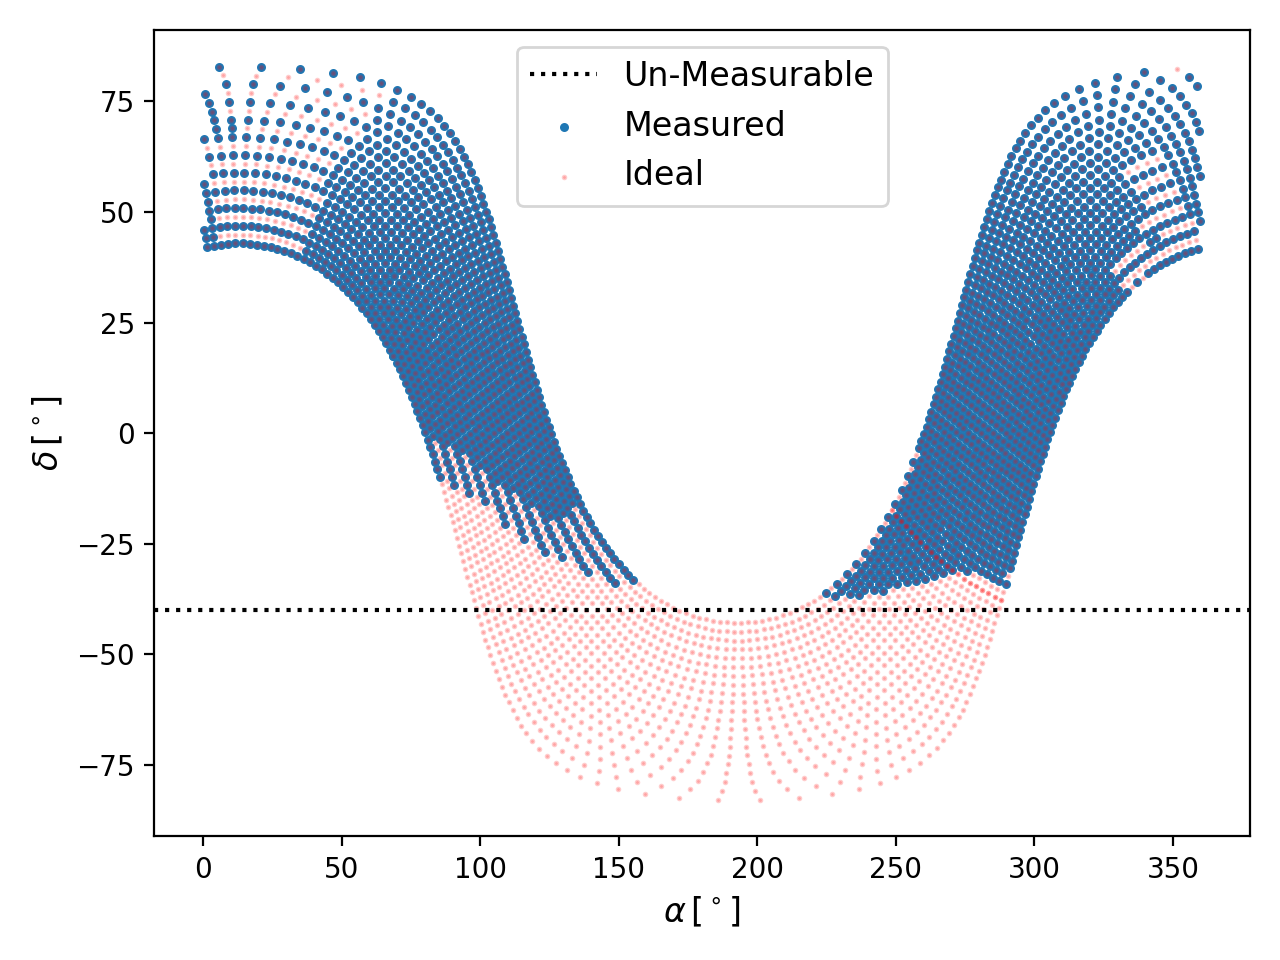

In [39]:
plt.figure()
plt.scatter(ra_used, dec_used, s=5, label='Measured')
plt.scatter(ra_wanted, dec_wanted, s=1, alpha=.2, c='r', label='Ideal')
plt.axhline(-40, ls=':', color='k', label='Un-Measurable')
plt.legend(fontsize='12')
plt.xlabel(r'$\alpha\,[ ^\circ]$', fontsize='12')
plt.ylabel(r'$\delta\,[ ^\circ]$', fontsize='12')
plt.tight_layout()
plt.savefig('pointings.pdf')

In [3]:
ls = np.arange(0, 360+1, 2)
bs = np.arange(-20, 20+1, 4)
best_start = []
hr = 22
day = 14
time = astropy.time.Time(f'2020-4-{day} {hr}:45')
Leusch = EarthLocation(lat=37.91934, lon=122.15385, height=304*u.m)

observing_time = astropy.time.Time(time)
aa = AltAz(location=Leusch, obstime=observing_time)

grid = np.zeros((len(ls), len(bs), 2))
grid_lb = grid.copy()
bad_coords = []
counter = 0
for i, l in enumerate(ls):
    for j,b in enumerate(bs):
        if counter%4 !=0:
            b = -b
        grid_lb[i, j] = l,b                                                  # Store the l and bs in thier own array for easy viewing
        c = SkyCoord(l, b, frame='galactic',unit='deg')   
        ra_dec = c.transform_to('fk5')                                       # convert the l,b to ra, dec and store in grid
        grid[i,j,0]  = ra_dec.ra.radian
        grid[i, j, 1] = ra_dec.dec.radian
        if ra_dec.dec.degree <-40:
            bad_coords.append((l, b))
        else:
            continue
        
        # We want to find a starting coordinate that is close to the horizon and moving up
    
        a = c.transform_to(aa)                                               # convert to ant az
        if a.alt.radian*180/np.pi >10 and a.alt.radian*180/np.pi < 11:       # find the indices that are near horizon to begin with

            # Find the altitudes at a later time to find which have come over head
            new_time = astropy.time.Time(f'2020-4-{day} {hr+1}:00')                   
            new_aa = AltAz(location=Leusch, obstime=new_time)                
            new_a = c.transform_to(new_aa)
            if new_a.alt.radian*180/np.pi < a.alt.radian*180/np.pi and j==0:
                # Append those coordinates to a list
                best_start.append((i,j))
    
    counter +=1
        

In [454]:
len(bad_coords)

447

In [4]:
g = start_generator(grid, int(0), 0)
g_lb = start_generator(grid_lb, int(0), 0)
pointings = np.array([coord for coord in g])
pointings_lb = np.array([coord for coord in g_lb])

NameError: name 'start_generator' is not defined

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [10]:
pointings[0]

array([ 5.02717674, -0.65683292])

<IPython.core.display.Javascript object>


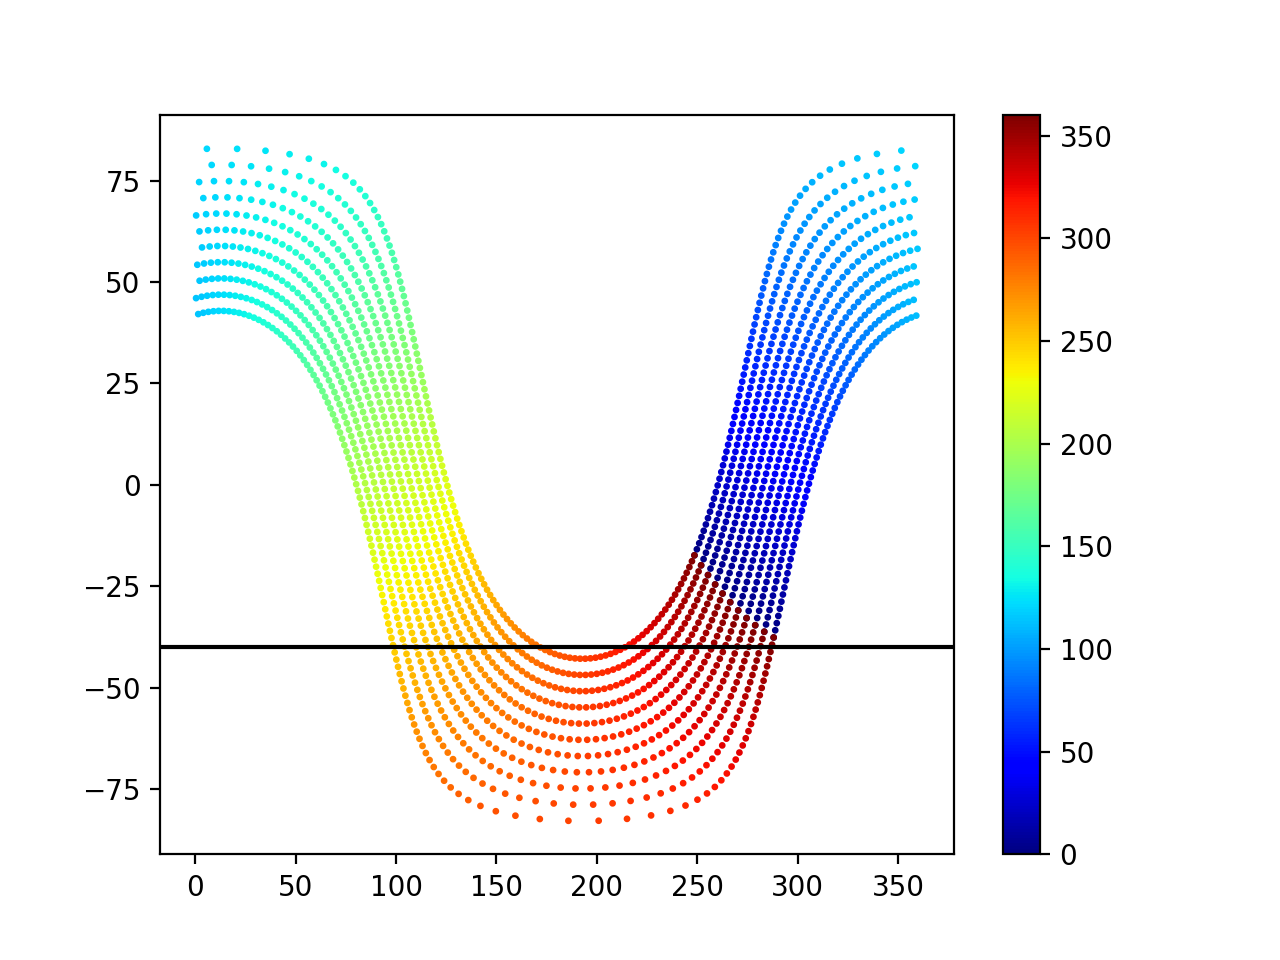

In [11]:
plt.figure()
plt.scatter(pointings[:,0]*180/np.pi,pointings[:,1]*180/np.pi , s=2, c=pointings_lb[:,0], cmap='jet')
plt.axhline(-40, c='k')


plt.colorbar()

In [25]:
# The Galactic Plane
lmin = 0; lmax = 360
bmin = -20; bmax = 20

coordinates = []
b = np.arange(-20,20,step=4)
for bi in b:
    l = lmin
    while l<lmax:
        coordinates.append((l,bi))
        l += 2/np.cos(np.radians(bi))

<IPython.core.display.Javascript object>


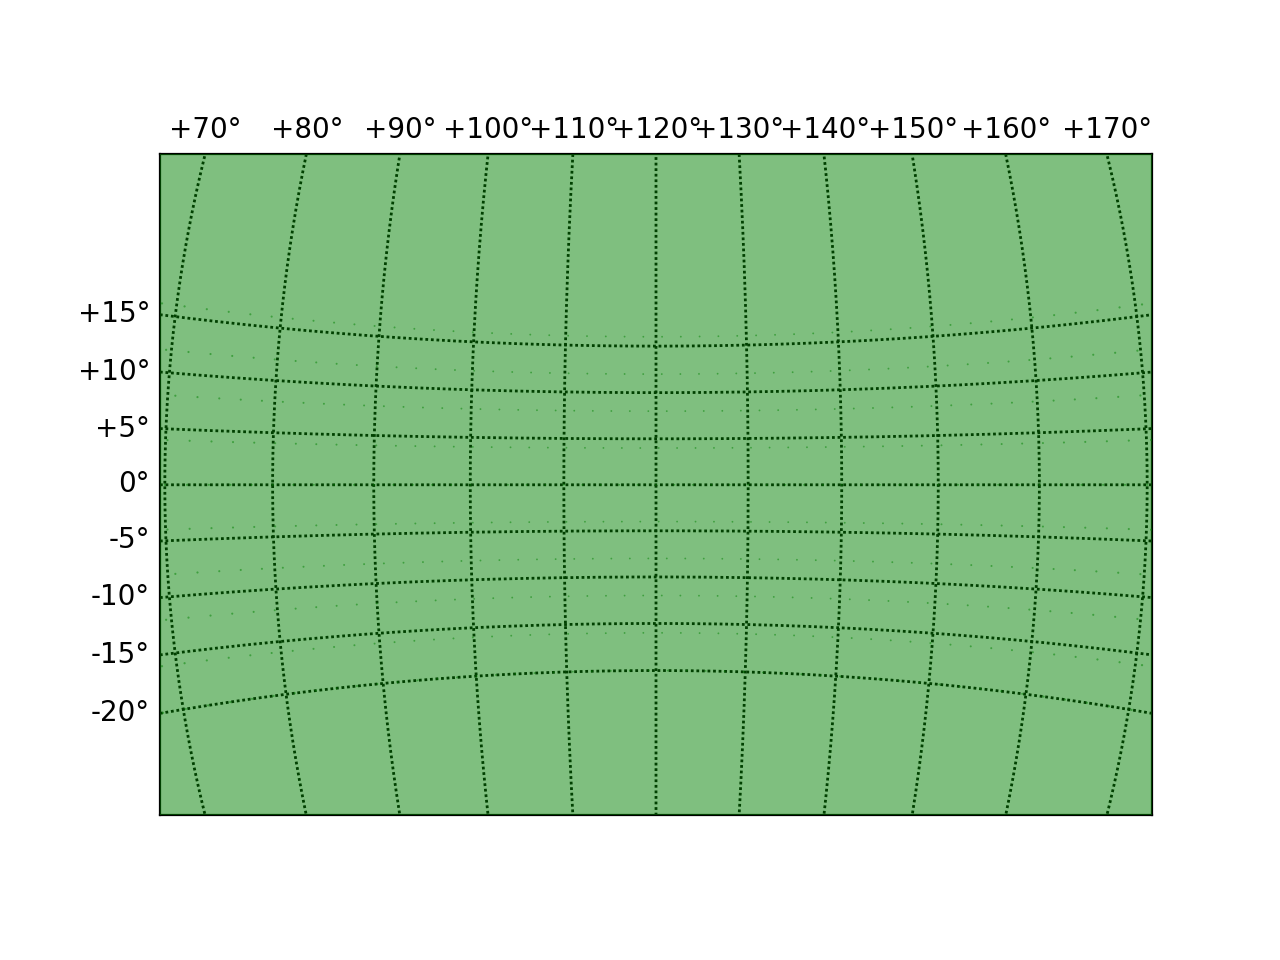

In [35]:
plt.figure()
m = basemap.Basemap(projection='stere',  # Stereographic projection
            width = 12000000,
            height = 8000000,
            lon_0 = 120,        # Rightmost extent
            lat_0 = 0)          # Center latitude
m.drawparallels(np.arange(-20,20,5), labels=[1,0,0,0], labelstyle='+/-')
m.drawmeridians(np.arange(-10,250,10), labels=[0,0,1,0], labelstyle='+/-')
for x,y in coordinates:
    poly = m.tissot(x,y,.1,10,facecolor='green',zorder=10,alpha=0.5)
plt.show()

In [12]:
pointings_altaz = pointings.copy()

<IPython.core.display.Javascript object>


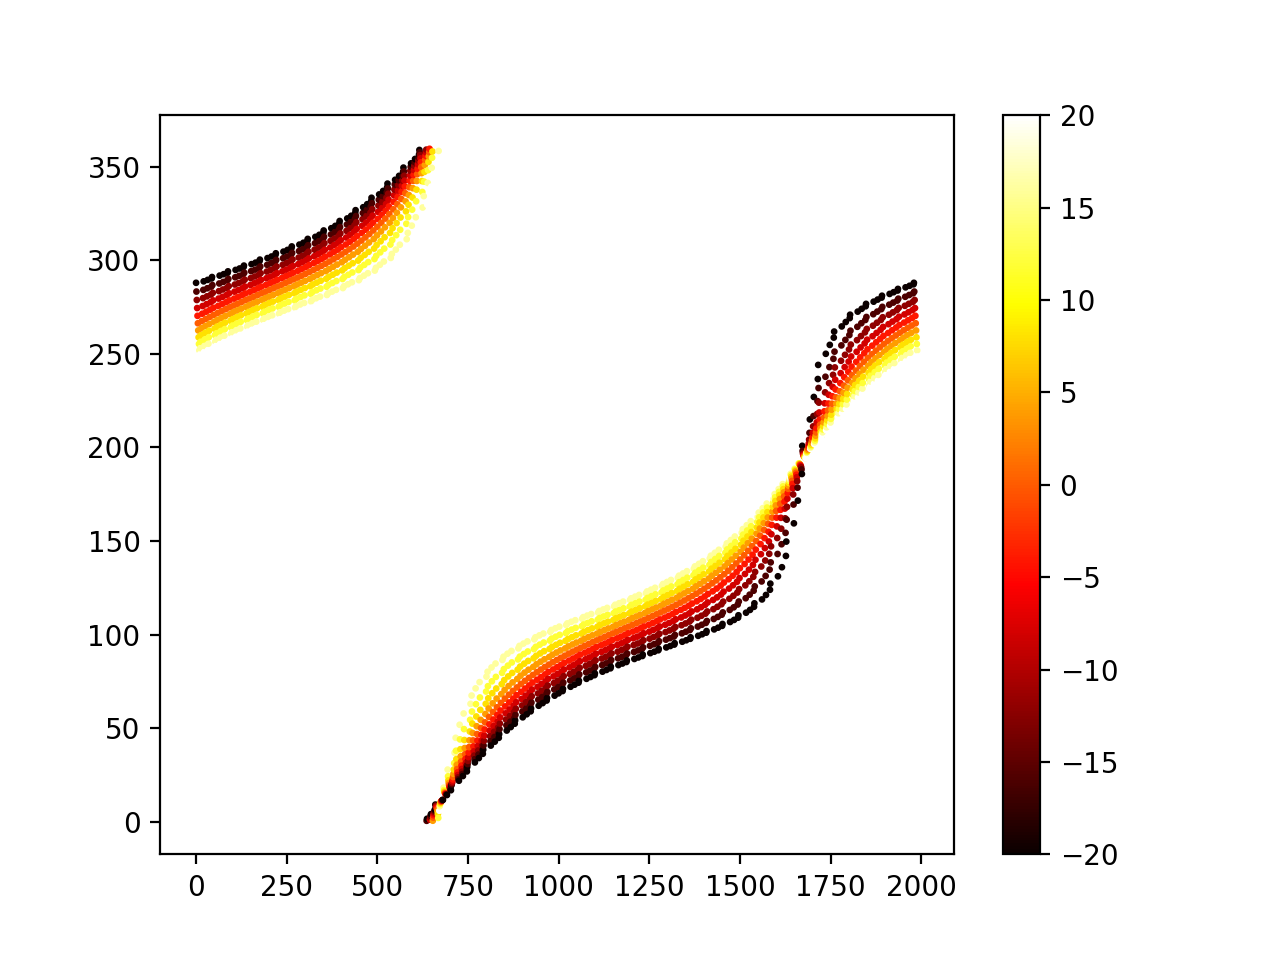

In [945]:
plt.figure()
plt.scatter(np.arange(len(pointings)),pointings[:,0]*180/np.pi , s=2, c=pointings_lb[:,1], cmap='hot')
plt.colorbar()

# Calibration

In [946]:
hdul_on  = io.fits.open('cal/1270.0_140.0_70.0_noise_on.fits')
hdul_off = io.fits.open('cal/1270.0_140.0_70.0_noise_off.fits')

In [949]:
xx_on = hdul_on[1].data['auto0_real']
xx_off = hdul_off[1].data['auto0_real']

<IPython.core.display.Javascript object>


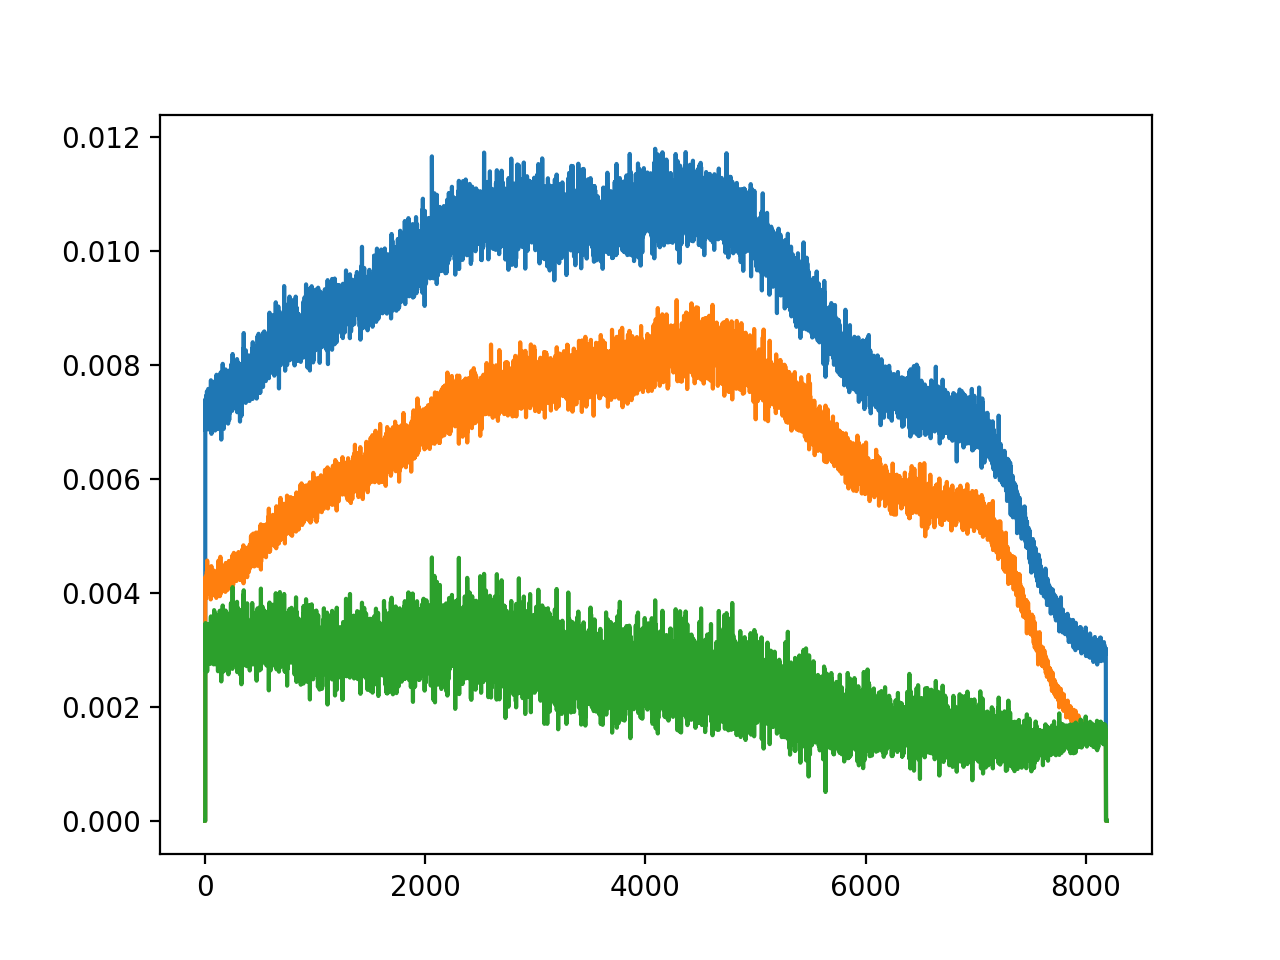

In [1019]:
plt.figure()
plt.plot(xx_on)
plt.plot(xx_off)
plt.plot(xx_on-xx_off)

In [1048]:
cal = 80/(np.median(xx_on)-np.median(xx_off))

In [1049]:
cal

30612.526363412657

# Files

In [1050]:
from astropy import io

In [1051]:
file = 'cas.fits'

In [1052]:
def fitter(dat, t):
    fit = np.polyfit(t, dat, 40)
    dat -= poly(t, fit)
    return dat

def hdul_avg(file):
    hdul = io.fits.open(file)
    avg = np.zeros((8192, 4))
    t = np.linspace(1e6, 11e6, 8192)


    for i,h in enumerate(hdul):
        if i !=0:
            real0, real1 = h.data.auto0_real, h.data.auto1_real
            cross_real, cross_imag = h.data.cross_real, h.data.cross_imag
            
            
            
            avg[:,0] += real0
            avg[:,1] += real1
            avg[:, 2] +=cross_real
            avg[:,3] += cross_imag
    avg = avg/i
    return hdul, avg

def hdul_save(avg, path, file):
    np.savez(path+file, real0=avg[:,0], real1=avg[:,1], cross_real=avg[:,2], cross_imag=avg[:,3])

In [1053]:
hdul, avg = hdul_avg(file)

In [1054]:
spec = hdul[1].data.auto0_real*cal

In [1055]:
%matplotlib notebook

In [910]:
np.polyfit()

array([-1.50826317e-104,  1.67701334e-098,  1.65339511e-086,
        3.12004706e-077,  3.86425943e-068,  3.12301951e-059,
       -1.22511597e-052, -6.29716487e-041, -1.55858354e-031,
       -2.52125188e-022, -2.67618973e-013,  5.52514097e-007,
        9.86055877e+005])

In [911]:
# def poly(x, n):
#     f=np.zeros_like(x)
#     for i, c in enumerate(n[::-1]):
#         f= f+ c*x**i
#     return f

def poly(x,y,d):
    pf = np.polyfit(x, y, deg = d)
    poly = 0
    for ii in range(d+1):
        a = pf[d-ii]*x**(ii)
        poly = poly+a
    return poly

In [1057]:

# t = np.linspace(1e6, 11e6, len(spec))
# t0 = t[:3948]
# t1 = t[4266:]

# fit = np.polyfit(t, spec, 40)
# f = poly(t, fit)
# spec -=f
# fit0 = np.polyfit(t0, spec[:3948], 40)
# fit1 = np.polyfit(t1, spec[4266:], 40)

# f0 = poly(t0, fit0)
# f1 = poly(t1, fit1)

<IPython.core.display.Javascript object>


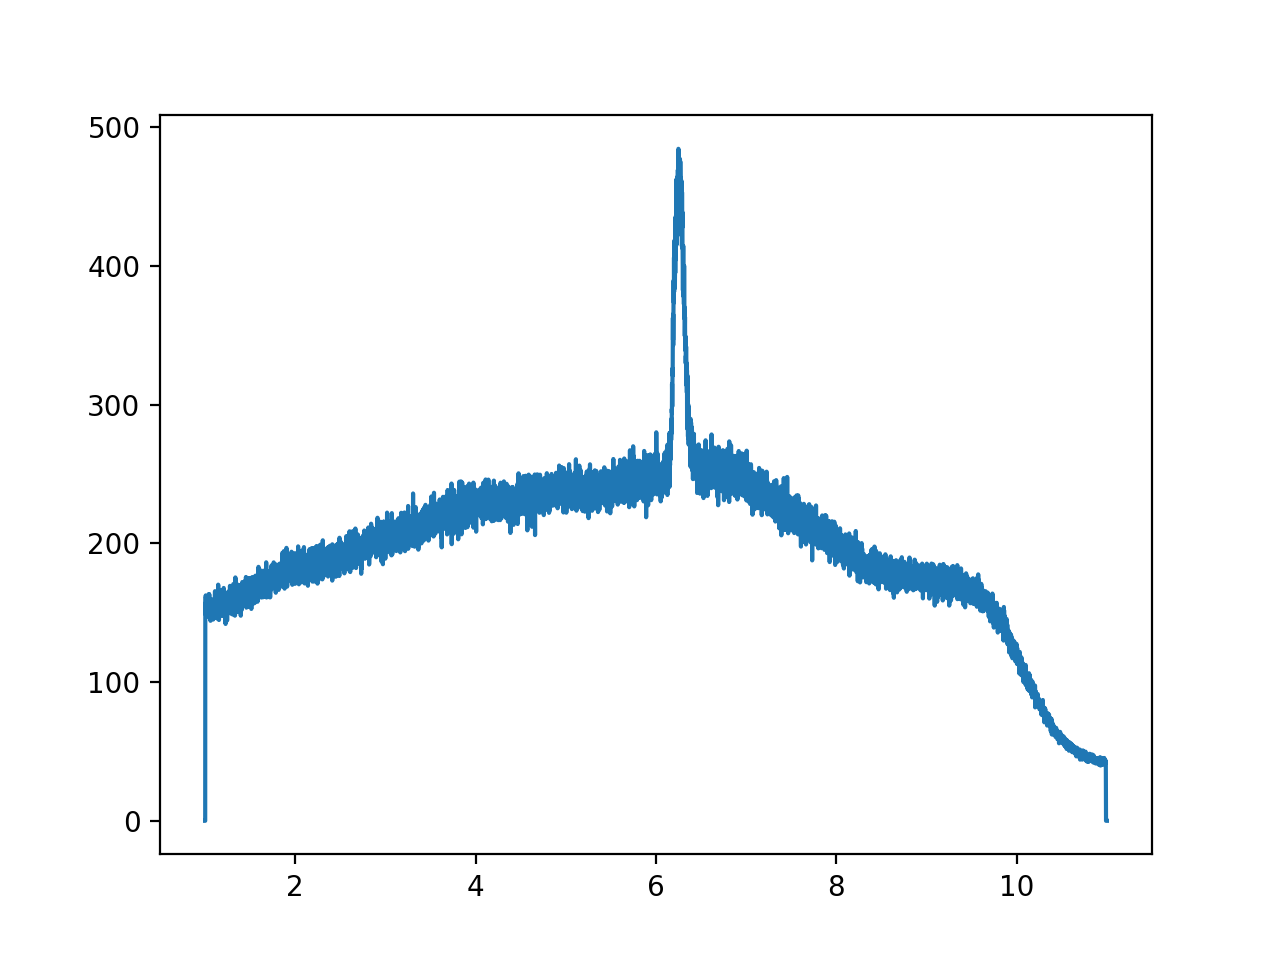

In [1058]:
plt.figure()
plt.plot(t/1e6, spec)
# plt.plot(t/1e6, av)


# plt.plot(t/1e6, f)
# plt.plot(t0/1e6, f0)
# plt.plot(t1/1e6, f1)
# plt.ylim(-.01, .01)
# plt.xlim(5, 7)
# plt.plot(avg[:,1])
# plt.plot(avg[:,2])
# plt.plot(avg[:,3])

# Avgs

In [1277]:
avg = np.load('avgs/1270.0_120.0_0.0_avg.npz', allow_pickle=True)

In [1278]:
def fix_sin(t, a, b, c, d):
    return a*np.sin(b*t+c)+d

In [1279]:
from scipy import optimize

In [3]:
r = avg['real0']



NameError: name 'avg' is not defined

In [1281]:
fit = np.polyfit(t, r, 10)
f = poly(t, fit)
r -=f


In [1282]:
fit, _ = optimize.curve_fit(fix_sin,t[:4259], r[:4259]*cal,p0=[75,3e-6,np.pi/3,0])

In [1283]:
fit

array([ 9.41467903e+00,  2.42255347e-06,  3.28476583e+00, -2.29885519e+00])

In [1301]:
t=np.linspace(145e6, 155e6, 8192)+1270e6

In [1]:
np.mean(r)

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


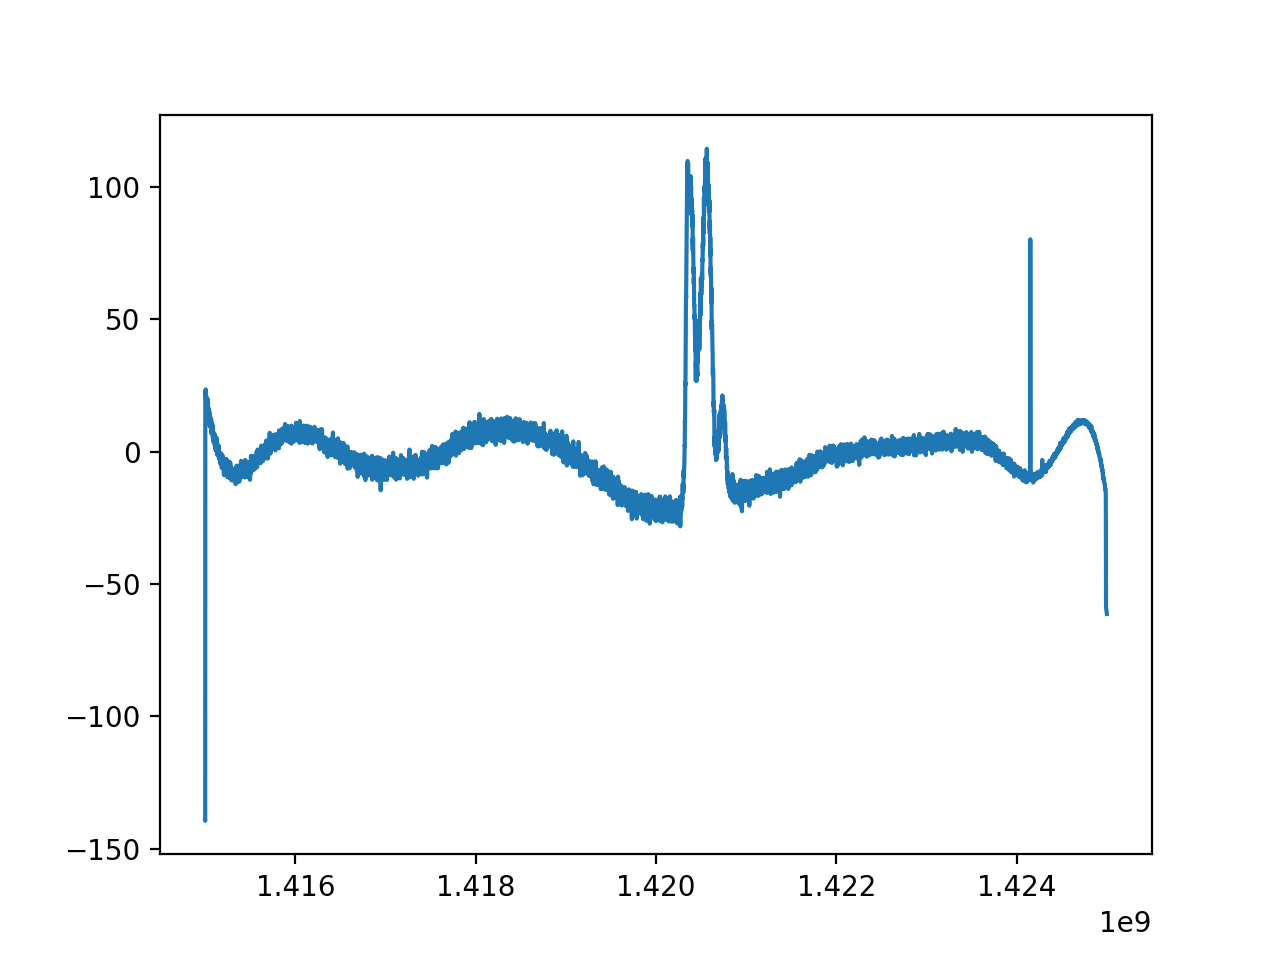

In [1303]:
plt.figure()
plt.plot(t, np.r*cal)
# plt.plot(t[:4259]/1e6, fix_sin(t[:4259], *fit))

In [1079]:
np.where(t/1e6 < 6.2)

(array([   0,    1,    2, ..., 4257, 4258, 4259]),)

In [8]:
import glob
from scipy.signal import savgol_filter

In [9]:
files = sorted(glob.glob('avgs/*.npz'))

In [10]:
def fit_data(t,data):
    dat = data.copy()
    for i,l in enumerate(dat):
        for j,b in enumerate(l):
            fit = np.polyfit(t, b, 10)
            f = poly(t, fit)
            b -=f
            dat[i,j] = b
    return dat

def fix_sin(t, data):
    dat = data.copy()
    for i,l in enumerate(dat):
        for j,b in enumerate(l):
            min_index = first_small_zero(b)
            max_index = first_big_zero(b)
            b = savgol_filter(b, 21, 3)
            b = fit_2(t, b, min_index, max_index)
            dat[i,j] = b
    return dat

def first_big_zero(dat):
    max_index = np.argmax(dat)
    not_zero=True
    while not_zero:
        max_index +=1
        if dat[max_index]<1e-6:
            return max_index
        
def first_small_zero(dat):
    max_index = np.argmax(dat)
    not_zero=True
    while not_zero:
        max_index -=1
        if dat[max_index]<1e-6:
            return max_index
        
def fit_2(t, y, min_index, max_index):
    t0 = t[:min_index]
    t1 = t[max_index:]

    fit0 = np.polyfit(t0, y[:min_index], 20)
    fit1 = np.polyfit(t1, y[max_index:], 20)

    f0 = poly(t0, fit0)
    f1 = poly(t1, fit1)
    
    y[:min_index] =y[:min_index]-f0
    y[max_index:] = y[max_index:]-f1
    
    return y

In [11]:
def file_sort(files):
    mw_grid = np.zeros((180, 22, 4, 8192))

    for f in files:
        lo, l, b, name = f.split('_')
        try:
            _, b = b.split('n')
            b = -float(b)
        except:
            b = int(float(b))
        if b==20:
            b=21
        elif b==18:
            b=20
        elif b==16:
            b=19
        elif b==14:
            b=18
        elif b ==14:
            b=17
        elif b==12:
            b=16
        elif b==10:
            b=15
        elif b==8:
            b=14
        elif b==6:
            b=13
        elif b ==4:
            b=12
        elif b==2:
            b=11
        elif b==0:
            b=10
        elif b==-2:
            b=9
        elif b==-4:
            b=8
        elif b ==-6:
            b=7
        elif b==-8:
            b=6
        elif b==-10:
            b=5
        elif b==-12:
            b=4
        elif b==-14:
            b=3
        elif b ==-16:
            b=2
        elif b==-18:
            b=1
        elif b==-20:
            b= 0
            
        
        l= int(float(l)/2)
        data = np.load(f, allow_pickle=True)
#         real0, real1, cross_real, cross_imag = fit_data(t, data)
        mw_grid[l,b,0] = data['real0']
        mw_grid[l,b,1] = data['real1']
        mw_grid[l,b,2] = data['cross_real']
        mw_grid[l,b,3] = data['cross_imag']
    return mw_grid    
        

In [12]:
grid = file_sort(files)
temp = grid[:,:,0,:]
# real = fit_data(t, temp)
# real = fix_sin(t, temp_mid)

In [13]:
grid.shape

(180, 22, 4, 8192)

In [14]:
r = temp[60,10, :]

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


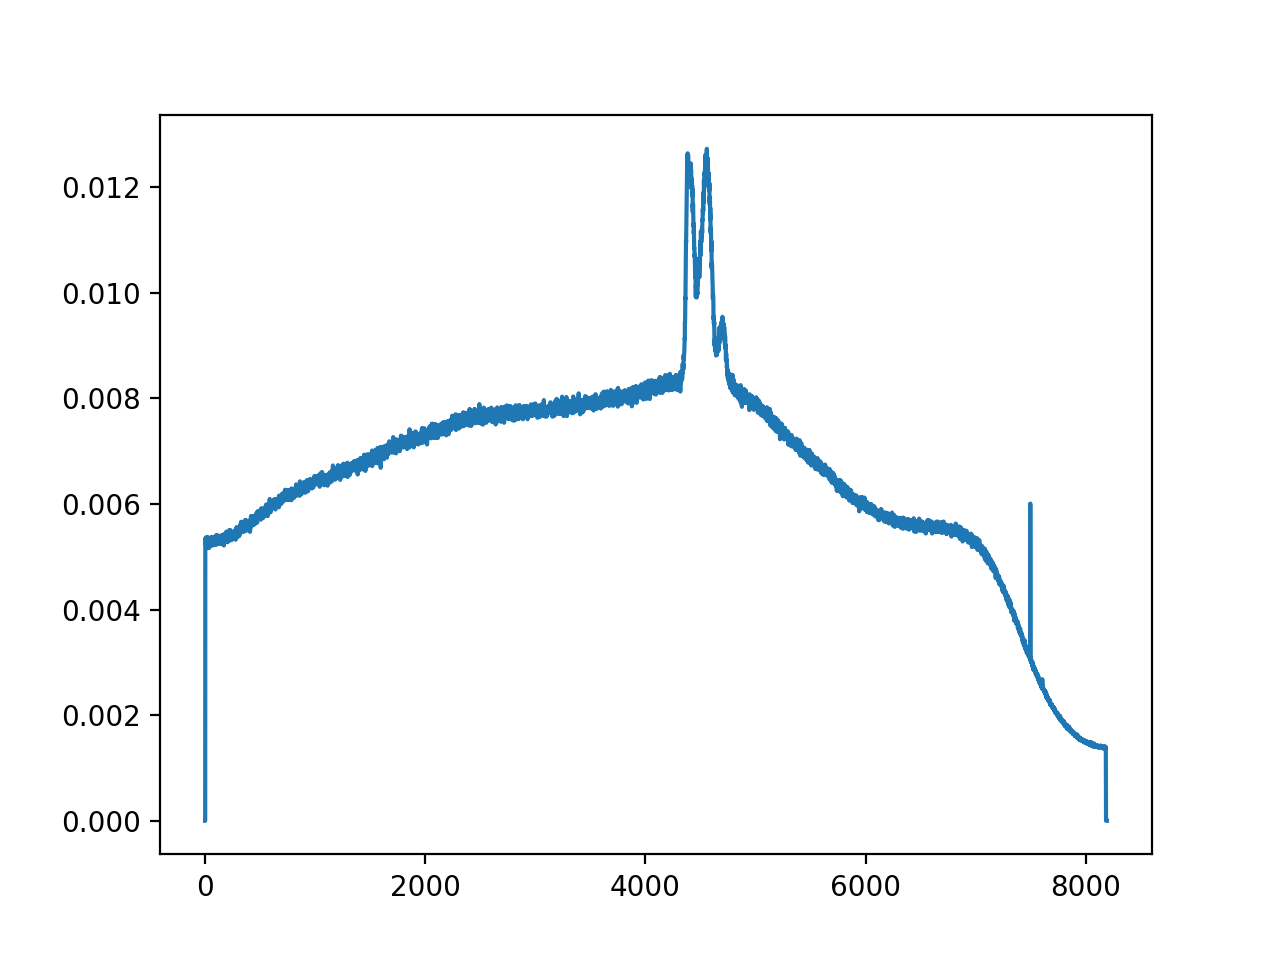

In [16]:
plt.figure()
plt.plot(r)

In [17]:
from matplotlib.colors import LogNorm

In [18]:
import scipy.interpolate as interp


In [19]:
t = np.linspace(145e6, 155e6, 8192)+1270e6

In [560]:
from scipy import optimize

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)

amps = np.array([25, 24])
means = np.array([6.3, 6.2])
sigs = np.array([.1, .01])
popt, _ = optimize.curve_fit(gaussian, t[3095:5464]/1e6, grid[85, 5, 3095:5464], p0=[amps[0], means[0], sigs[0]])


ValueError: `ydata` must not be empty!

In [561]:
g_fit = gaussian(t[3095:5464]/1e6, *popt)


NameError: name 'popt' is not defined

In [562]:
grid_lb[60, 5]

IndexError: index 5 is out of bounds for axis 1 with size 2

<IPython.core.display.Javascript object>


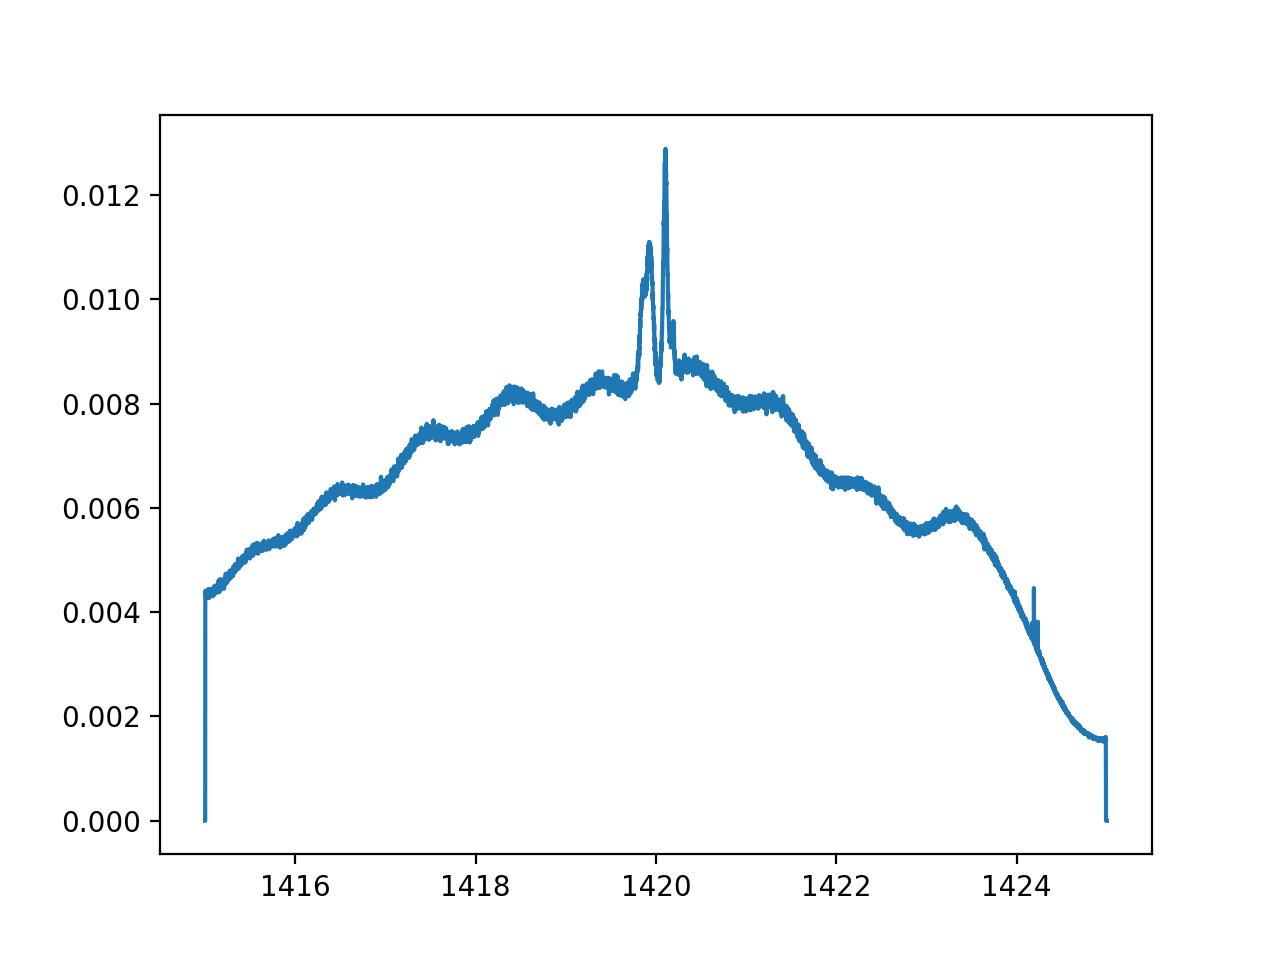

In [156]:
plt.figure()
plt.plot(t/1e6, temp[120, 10, :])
# plt.plot(t/1e6, temp_mid[85, 5,:])
# plt.plot(t[3095:5464]/1e6, g_fit)


# plt.plot(t/1e6, real[85, 5, :])
# plt.plot(t0, f0)
# plt.plot(t1, f1)

In [1423]:
np.where(t<6e6), np.where(t<6.45e6)

((array([], dtype=int64),), (array([], dtype=int64),))

In [94]:
grid[15,11,0].min()

0.0

In [157]:
test = grid[120, 10,0]
test = np.nan_to_num(test, 0)
test -= np.mean(test)

In [158]:
len(test)

8192

In [193]:
test_tilde = np.fft.fft(test)

In [194]:
grid.dtype

dtype('float64')

<IPython.core.display.Javascript object>


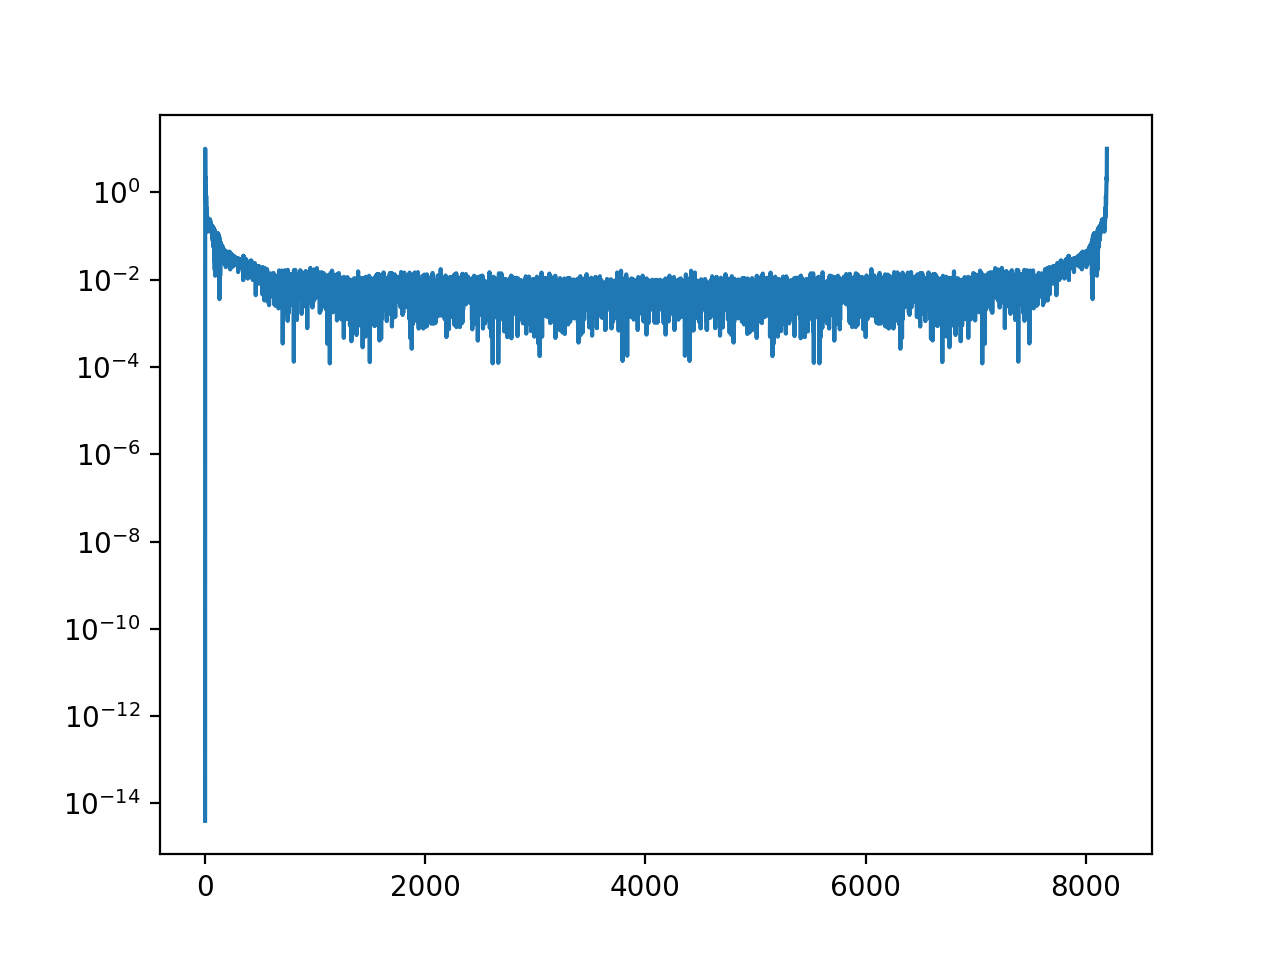

In [195]:
plt.figure()
# for i in range(10, 15):
#     plt.plot(grid[i, 5,0])

plt.semilogy(np.abs(test_tilde))


In [142]:
np.where(t<(10000+1.415e9))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),)

In [190]:
test_tilde[[-12, -11, -10,-9,-8,-7,-6,-5,-4, 4, -3,3, 5,  6, 7, 8, 9, 10, 11, 12]] = 0

In [200]:
test_tilde[[-4,-3, 3,4]]=0

In [201]:
test_back = np.fft.ifft(test_tilde)

<IPython.core.display.Javascript object>


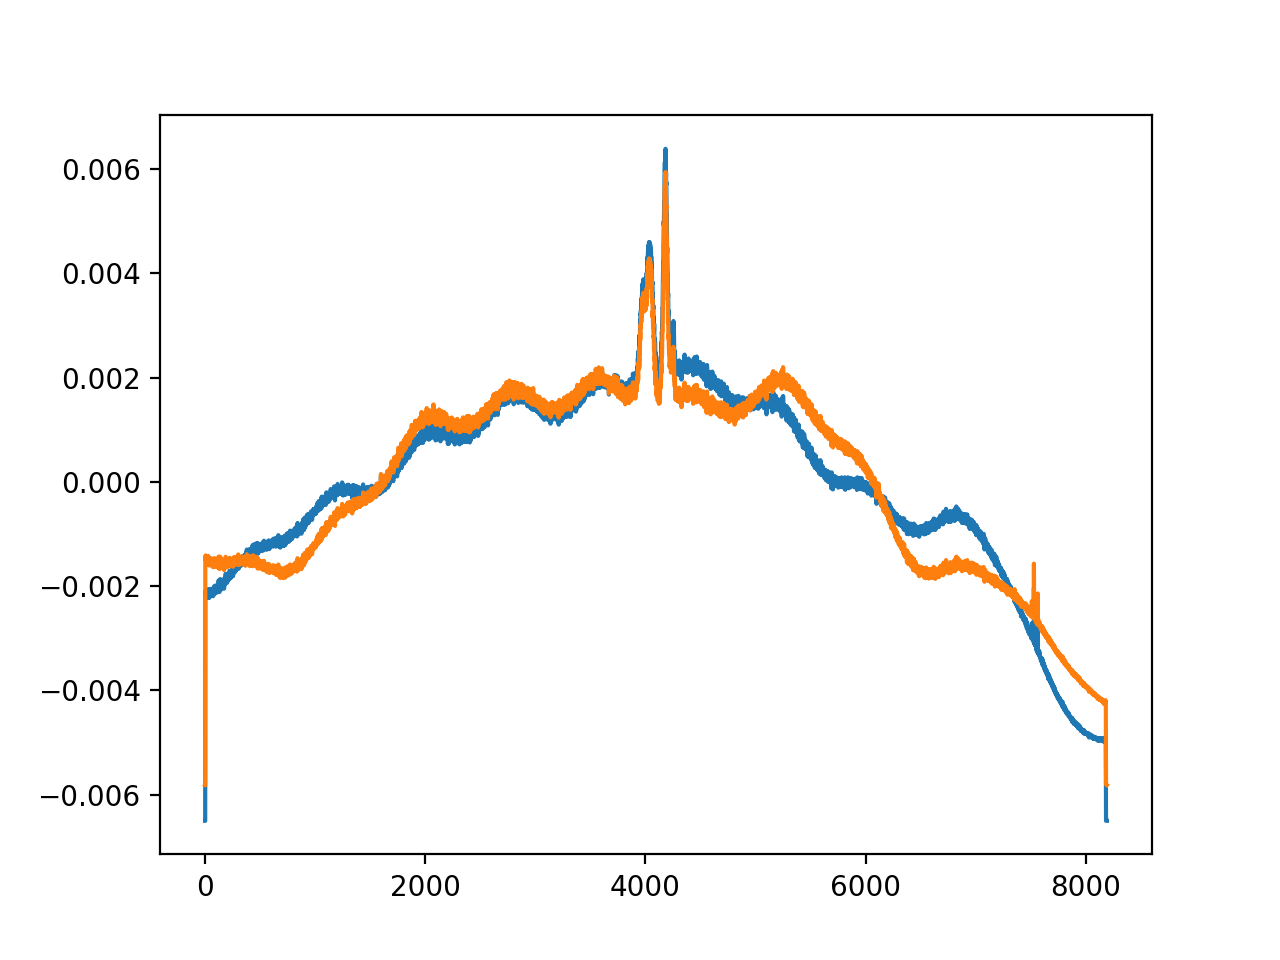

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [202]:
plt.figure()
plt.plot(test)
plt.plot(test_back)
# plt.plot(test)

In [1426]:
%matplotlib notebook

In [53]:
len(test)

NameError: name 'test' is not defined

In [410]:
grid.shape

AttributeError: 'list' object has no attribute 'shape'

In [419]:
grid[:, 4,0, :].shape

(180, 8192)

In [603]:
t

array([1.41500000e+09, 1.41500122e+09, 1.41500244e+09, ...,
       1.42499756e+09, 1.42499878e+09, 1.42500000e+09])

In [600]:
v = 3e8 * (1420.4e6 - t)/1420.4e6

In [ ]:
LSR = 

In [ ]:
q = np.meshgrid(ls, bs, grid[:,:,0,:])

<IPython.core.display.Javascript object>


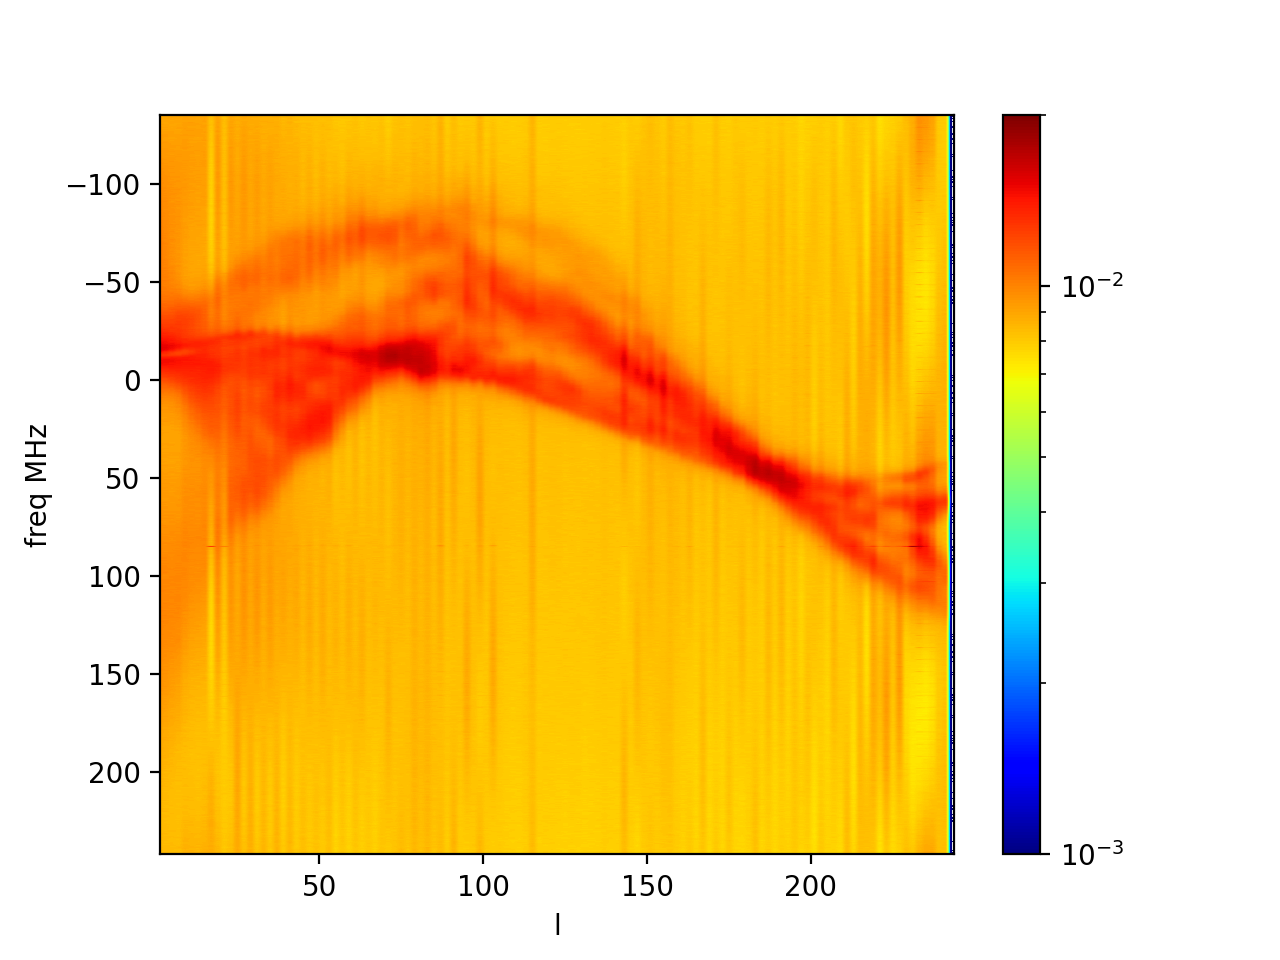

Text(0, 0.5, 'freq MHz')

In [605]:
plt.figure()
plt.imshow(grid[:, 10,0, :].T, aspect='auto',norm=LogNorm(1e-3, 2e-2), cmap='jet', extent=[0, 360, v[0]/1e3, v[-1]/1e3], origin='lower')
# for i in range(11):
#     plt.imshow(real[:, i,].T, aspect='auto', cmap='jet', alpha=.4-i*.01, norm=LogNorm(), extent=[0, 360, t[0]/1e6, t[-1]/1e6], origin='lower')

plt.colorbar()
# plt.ylim(1420, 1421)
plt.xlabel('l')
plt.ylabel('freq MHz')
# plt.imshow(real[:, 4], aspect='auto', norm=LogNorm(), alpha =.2)
# plt.imshow(real[:, 3], aspect='auto', norm=LogNorm(), alpha=.2)
# plt.imshow(real[:, 2], aspect='auto', norm=LogNorm(), alpha=.2)
# plt.imshow(real[:, 1], aspect='auto', norm=LogNorm(), alpha=.2)
# plt.imshow(real[:, 0], aspect='auto', norm=LogNorm(), alpha=.2)

In [46]:
import healpy as hp

ValueError: Wrong pixel number (it is not 12*nside**2)

In [2]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [1407]:
len(files)

1294

In [1412]:
to_view = []
for i,l in enumerate(ls.astype(np.float32)):
    for j,b in enumerate(bs.astype(np.float32)):
        # check Files:
        try:
            _, b = str(b).split('-')
            b = 'n'+b
        except:
            pass
        f_name = f'avgs/{1270.0}_{str(l)}_{b}_avg.npz'
        if os.path.exists(f_name):
            pass
        else:
            if not (l, bs[j]) in bad_coords:
                print((l, bs[j]))
                to_view.append((l,bs[j]))

(0.0, -20)
(0.0, -16)
(0.0, -12)
(0.0, -8)
(0.0, -4)
(0.0, 0)
(0.0, 4)
(0.0, 8)
(0.0, 20)
(2.0, -20)
(2.0, -16)
(2.0, -12)
(2.0, -8)
(2.0, -4)
(2.0, 0)
(2.0, 4)
(2.0, 8)
(4.0, -20)
(4.0, -16)
(4.0, -12)
(4.0, -8)
(4.0, -4)
(4.0, 0)
(4.0, 4)
(4.0, 8)
(4.0, 20)
(6.0, -20)
(6.0, -16)
(6.0, -12)
(6.0, -8)
(6.0, -4)
(6.0, 0)
(6.0, 4)
(6.0, 8)
(8.0, -20)
(8.0, -16)
(8.0, -12)
(8.0, -8)
(8.0, -4)
(8.0, 0)
(8.0, 4)
(8.0, 20)
(10.0, -4)
(10.0, 0)
(10.0, 4)
(12.0, 0)
(12.0, 4)
(12.0, 20)
(16.0, 20)
(90.0, -20)
(94.0, -20)
(120.0, 20)
(216.0, -20)
(218.0, -20)
(220.0, -20)
(220.0, -16)
(222.0, -20)
(222.0, -16)
(224.0, -20)
(224.0, -16)
(224.0, -12)
(226.0, -20)
(226.0, -16)
(226.0, -12)
(228.0, -20)
(228.0, -16)
(228.0, -12)
(228.0, -8)
(230.0, -20)
(230.0, -16)
(230.0, -12)
(230.0, -8)
(232.0, -20)
(232.0, -16)
(232.0, -12)
(232.0, -8)
(234.0, -20)
(234.0, -16)
(234.0, -12)
(234.0, -8)
(236.0, -20)
(236.0, -16)
(236.0, -12)
(236.0, -8)
(236.0, -4)
(238.0, -20)
(238.0, -16)
(238.0, -12)
(238.0, 

In [1413]:
np.array(to_view).shape

(250, 2)

In [1410]:
bad_coords

[(125, 10),
 (126, 8),
 (126, 9),
 (126, 10),
 (127, 8),
 (127, 9),
 (127, 10),
 (128, 0),
 (128, 1),
 (128, 2),
 (128, 3),
 (129, 6),
 (129, 7),
 (129, 8),
 (129, 9),
 (129, 10),
 (130, 5),
 (130, 6),
 (130, 7),
 (130, 8),
 (130, 9),
 (130, 10),
 (131, 5),
 (131, 6),
 (131, 7),
 (131, 8),
 (131, 9),
 (131, 10),
 (132, 0),
 (132, 1),
 (132, 2),
 (132, 3),
 (132, 4),
 (132, 5),
 (132, 6),
 (133, 4),
 (133, 5),
 (133, 6),
 (133, 7),
 (133, 8),
 (133, 9),
 (133, 10),
 (134, 3),
 (134, 4),
 (134, 5),
 (134, 6),
 (134, 7),
 (134, 8),
 (134, 9),
 (134, 10),
 (135, 3),
 (135, 4),
 (135, 5),
 (135, 6),
 (135, 7),
 (135, 8),
 (135, 9),
 (135, 10),
 (136, 0),
 (136, 1),
 (136, 2),
 (136, 3),
 (136, 4),
 (136, 5),
 (136, 6),
 (136, 7),
 (136, 8),
 (137, 2),
 (137, 3),
 (137, 4),
 (137, 5),
 (137, 6),
 (137, 7),
 (137, 8),
 (137, 9),
 (137, 10),
 (138, 2),
 (138, 3),
 (138, 4),
 (138, 5),
 (138, 6),
 (138, 7),
 (138, 8),
 (138, 9),
 (138, 10),
 (139, 1),
 (139, 2),
 (139, 3),
 (139, 4),
 (139, 5),

<IPython.core.display.Javascript object>


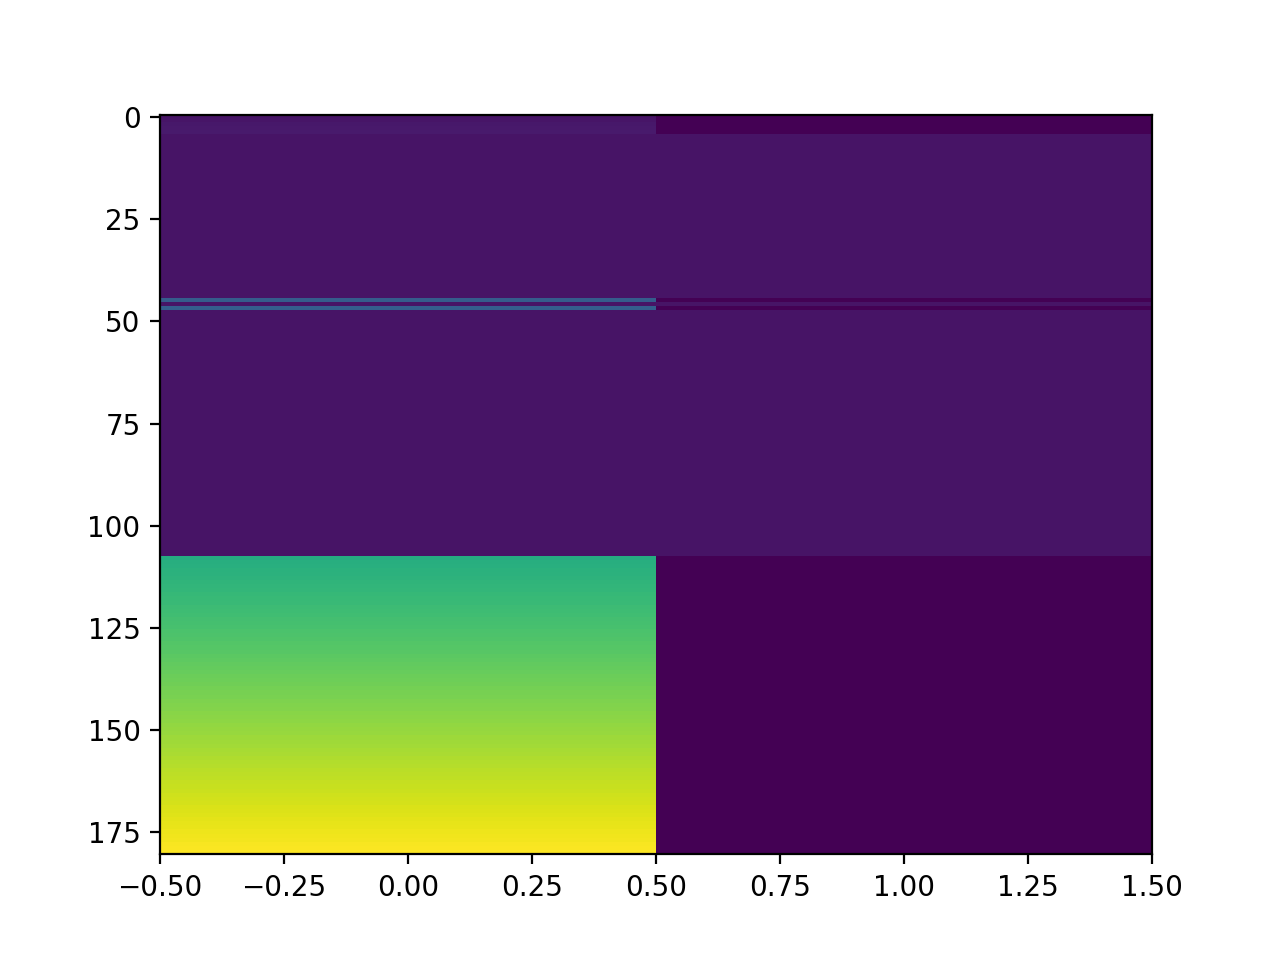

In [1405]:
plt.figure()
plt.imshow(file_grid[:,0], aspect='auto')

In [1347]:
new_grid.shape

()

<IPython.core.display.Javascript object>


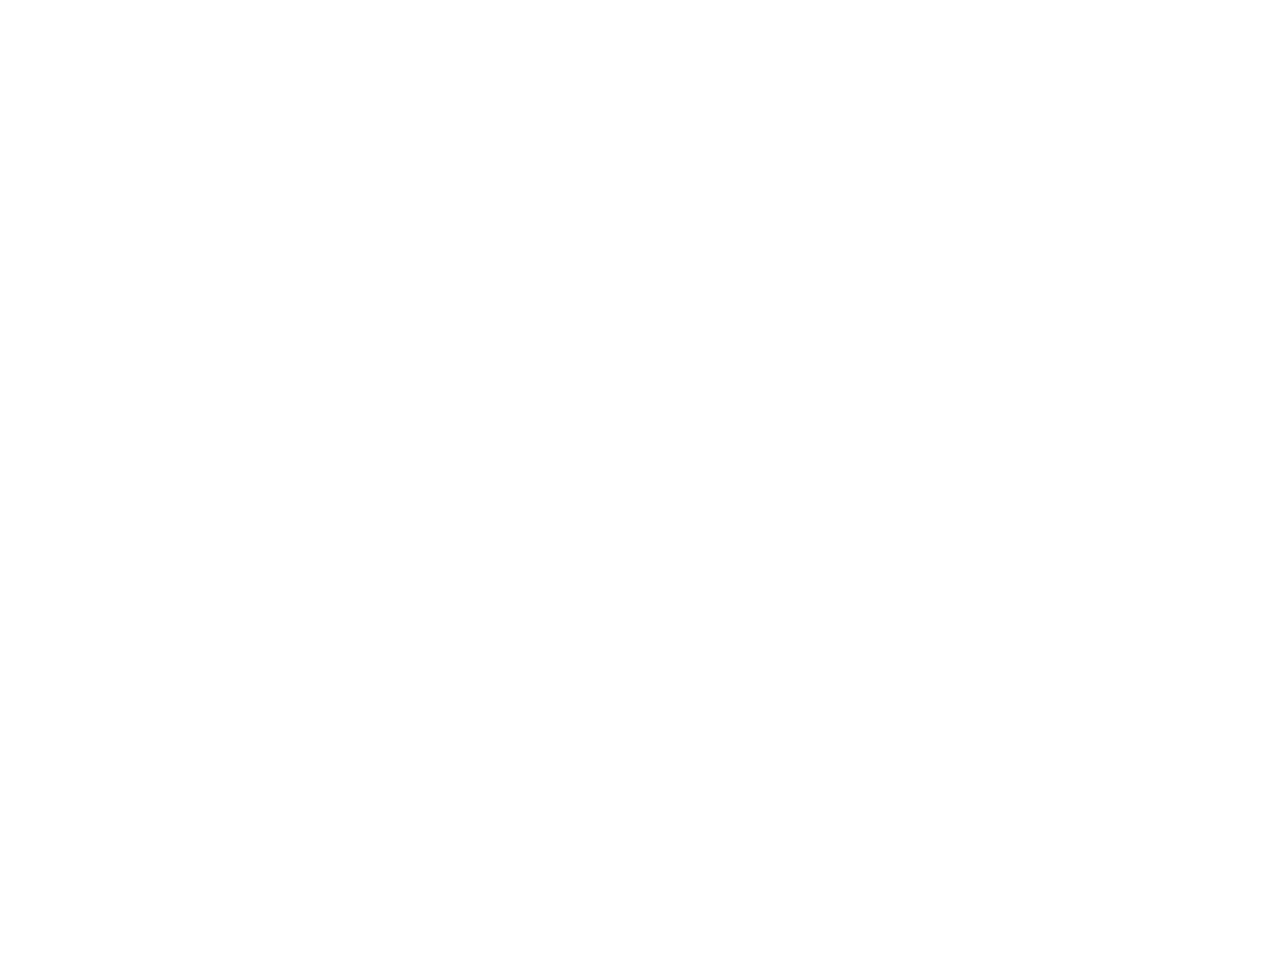

IndexError: invalid index to scalar variable.

In [186]:
time = astropy.time.Time(f'2020-4-{day} {hr}:45')
Leusch = EarthLocation(lat=37.91934*u.degree, lon=122.15385*u.degree, height=304*u.m)
# jd = np.linspace(2458948, 2458949, 100)
times = astropy.time.Time([f'2020-4-{19} {i}:00' for i in range(24)])
observing_time = astropy.time.Time(times, format='datetime')
aa = AltAz(location=Leusch, obstime=observing_time)

In [332]:
a = SkyCoord(356, -18, frame='galactic',unit='deg')

In [333]:
import os

In [334]:
a.fk5.dec.degree

-40.50367403914094

In [193]:
b = a.transform_to(aa)

In [194]:
len(b)

24

In [195]:
times[np.where(b.alt.radian*180/np.pi >15)]

<Time object: scale='utc' format='iso' value=['2020-04-19 01:00:00.000' '2020-04-19 02:00:00.000'
 '2020-04-19 03:00:00.000' '2020-04-19 04:00:00.000'
 '2020-04-19 05:00:00.000' '2020-04-19 06:00:00.000'
 '2020-04-19 07:00:00.000' '2020-04-19 08:00:00.000'
 '2020-04-19 09:00:00.000' '2020-04-19 10:00:00.000'
 '2020-04-19 11:00:00.000' '2020-04-19 12:00:00.000'
 '2020-04-19 13:00:00.000' '2020-04-19 14:00:00.000']>

In [176]:
b.alt

<Latitude [ 43.97693439,  41.25958172,  38.56582469,  35.89771828,
            33.25744814,  30.64734212,  28.06988225,  25.52771716,
            23.02367457,  20.560774  ,  18.14223927,  15.7715105 ,
            13.45225526,  11.18837835,   8.98402956,   6.84360862,
             4.77176656,   2.77340231,   0.85365345,  -0.98212015,
            -2.72836117,  -4.37934928,  -5.92924657,  -7.37215455,
            -8.70218333,  -9.91353285, -11.0005847 , -11.95800355,
           -12.78084413, -13.4646606 , -14.0056132 , -14.40056692,
           -14.6471765 , -14.74395287, -14.69030637, -14.48656428,
           -14.13396107, -13.63460228, -12.9914044 , -12.20801466,
           -11.28871575, -10.23832085,  -9.06206461,  -7.76549487,
            -6.35436945,  -4.83456129,  -3.21197402,  -1.4924693 ,
             0.3181937 ,   2.21440691,   4.19075091,   6.24202236,
             8.36325266,  10.54971911,  12.79694987,  15.10072384,
            17.45706668,  19.8622437 ,  22.31275068,  24.80530

In [198]:
test_dict = {i:[j for j in range(5)] for i in range(2)}

In [213]:
str((120, 0))

'(120, 0)'

In [320]:
ls = np.arange(0, 361, 2, dtype=np.float32)
bs = np.arange(-20, 21, 2, dtype=np.float32)
g, g_lb = make_grid(ls, bs)

In [497]:
len(grid_lb) - len(os.listdir('avgs/'))

1642

In [495]:
len(test_lb)

2289

In [321]:
for l,b in g_lb:
    print(l,b)

0.0 -20.0
0.0 -18.0
0.0 -16.0
0.0 -14.0
0.0 -12.0
0.0 -10.0
0.0 -8.0
0.0 -6.0
0.0 -4.0
0.0 -2.0
0.0 0.0
0.0 2.0
0.0 4.0
0.0 6.0
0.0 8.0
0.0 10.0
0.0 12.0
0.0 14.0
0.0 16.0
0.0 18.0
0.0 20.0
2.0 20.0
2.0 18.0
2.0 16.0
2.0 14.0
2.0 12.0
2.0 10.0
2.0 8.0
2.0 6.0
2.0 4.0
2.0 2.0
2.0 -0.0
2.0 -2.0
2.0 -4.0
2.0 -6.0
2.0 -8.0
2.0 -10.0
2.0 -12.0
2.0 -14.0
2.0 -16.0
2.0 -18.0
2.0 -20.0
4.0 -20.0
4.0 -18.0
4.0 -16.0
4.0 -14.0
4.0 -12.0
4.0 -10.0
4.0 -8.0
4.0 -6.0
4.0 -4.0
4.0 -2.0
4.0 0.0
4.0 2.0
4.0 4.0
4.0 6.0
4.0 8.0
4.0 10.0
4.0 12.0
4.0 14.0
4.0 16.0
4.0 18.0
4.0 20.0
6.0 20.0
6.0 18.0
6.0 16.0
6.0 14.0
6.0 12.0
6.0 10.0
6.0 8.0
6.0 6.0
6.0 4.0
6.0 2.0
6.0 -0.0
6.0 -2.0
6.0 -4.0
6.0 -6.0
6.0 -8.0
6.0 -10.0
6.0 -12.0
6.0 -14.0
6.0 -16.0
6.0 -18.0
6.0 -20.0
8.0 -20.0
8.0 -18.0
8.0 -16.0
8.0 -14.0
8.0 -12.0
8.0 -10.0
8.0 -8.0
8.0 -6.0
8.0 -4.0
8.0 -2.0
8.0 0.0
8.0 2.0
8.0 4.0
8.0 6.0
8.0 8.0
8.0 10.0
8.0 12.0
8.0 14.0
8.0 16.0
8.0 18.0
8.0 20.0
10.0 20.0
10.0 18.0
10.0 16.0
10.0 14.0
10.0 12.

102.0 10.0
102.0 8.0
102.0 6.0
102.0 4.0
102.0 2.0
102.0 -0.0
102.0 -2.0
102.0 -4.0
102.0 -6.0
102.0 -8.0
102.0 -10.0
102.0 -12.0
102.0 -14.0
102.0 -16.0
102.0 -18.0
102.0 -20.0
104.0 -20.0
104.0 -18.0
104.0 -16.0
104.0 -14.0
104.0 -12.0
104.0 -10.0
104.0 -8.0
104.0 -6.0
104.0 -4.0
104.0 -2.0
104.0 0.0
104.0 2.0
104.0 4.0
104.0 6.0
104.0 8.0
104.0 10.0
104.0 12.0
104.0 14.0
104.0 16.0
104.0 18.0
104.0 20.0
106.0 20.0
106.0 18.0
106.0 16.0
106.0 14.0
106.0 12.0
106.0 10.0
106.0 8.0
106.0 6.0
106.0 4.0
106.0 2.0
106.0 -0.0
106.0 -2.0
106.0 -4.0
106.0 -6.0
106.0 -8.0
106.0 -10.0
106.0 -12.0
106.0 -14.0
106.0 -16.0
106.0 -18.0
106.0 -20.0
108.0 -20.0
108.0 -18.0
108.0 -16.0
108.0 -14.0
108.0 -12.0
108.0 -10.0
108.0 -8.0
108.0 -6.0
108.0 -4.0
108.0 -2.0
108.0 0.0
108.0 2.0
108.0 4.0
108.0 6.0
108.0 8.0
108.0 10.0
108.0 12.0
108.0 14.0
108.0 16.0
108.0 18.0
108.0 20.0
110.0 20.0
110.0 18.0
110.0 16.0
110.0 14.0
110.0 12.0
110.0 10.0
110.0 8.0
110.0 6.0
110.0 4.0
110.0 2.0
110.0 -0.0
110.0 -2

172.0 20.0
174.0 20.0
174.0 18.0
174.0 16.0
174.0 14.0
174.0 12.0
174.0 10.0
174.0 8.0
174.0 6.0
174.0 4.0
174.0 2.0
174.0 -0.0
174.0 -2.0
174.0 -4.0
174.0 -6.0
174.0 -8.0
174.0 -10.0
174.0 -12.0
174.0 -14.0
174.0 -16.0
174.0 -18.0
174.0 -20.0
176.0 -20.0
176.0 -18.0
176.0 -16.0
176.0 -14.0
176.0 -12.0
176.0 -10.0
176.0 -8.0
176.0 -6.0
176.0 -4.0
176.0 -2.0
176.0 0.0
176.0 2.0
176.0 4.0
176.0 6.0
176.0 8.0
176.0 10.0
176.0 12.0
176.0 14.0
176.0 16.0
176.0 18.0
176.0 20.0
178.0 20.0
178.0 18.0
178.0 16.0
178.0 14.0
178.0 12.0
178.0 10.0
178.0 8.0
178.0 6.0
178.0 4.0
178.0 2.0
178.0 -0.0
178.0 -2.0
178.0 -4.0
178.0 -6.0
178.0 -8.0
178.0 -10.0
178.0 -12.0
178.0 -14.0
178.0 -16.0
178.0 -18.0
178.0 -20.0
180.0 -20.0
180.0 -18.0
180.0 -16.0
180.0 -14.0
180.0 -12.0
180.0 -10.0
180.0 -8.0
180.0 -6.0
180.0 -4.0
180.0 -2.0
180.0 0.0
180.0 2.0
180.0 4.0
180.0 6.0
180.0 8.0
180.0 10.0
180.0 12.0
180.0 14.0
180.0 16.0
180.0 18.0
180.0 20.0
182.0 20.0
182.0 18.0
182.0 16.0
182.0 14.0
182.0 12.0
182.

244.0 8.0
244.0 10.0
244.0 12.0
244.0 14.0
244.0 16.0
244.0 18.0
244.0 20.0
246.0 20.0
246.0 18.0
246.0 16.0
246.0 14.0
246.0 12.0
246.0 10.0
246.0 8.0
246.0 6.0
246.0 4.0
246.0 2.0
246.0 -0.0
246.0 -2.0
246.0 -4.0
246.0 -6.0
246.0 -8.0
246.0 -10.0
246.0 -12.0
246.0 -14.0
246.0 -16.0
246.0 -18.0
246.0 -20.0
248.0 -20.0
248.0 -18.0
248.0 -16.0
248.0 -14.0
248.0 -12.0
248.0 -10.0
248.0 -8.0
248.0 -6.0
248.0 -4.0
248.0 -2.0
248.0 0.0
248.0 2.0
248.0 4.0
248.0 6.0
248.0 8.0
248.0 10.0
248.0 12.0
248.0 14.0
248.0 16.0
248.0 18.0
248.0 20.0
250.0 20.0
250.0 18.0
250.0 16.0
250.0 14.0
250.0 12.0
250.0 10.0
250.0 8.0
250.0 6.0
250.0 4.0
250.0 2.0
250.0 -0.0
250.0 -2.0
250.0 -4.0
250.0 -6.0
250.0 -8.0
250.0 -10.0
250.0 -12.0
250.0 -14.0
250.0 -16.0
252.0 -10.0
252.0 -8.0
252.0 -6.0
252.0 -4.0
252.0 -2.0
252.0 0.0
252.0 2.0
252.0 4.0
252.0 6.0
252.0 8.0
252.0 10.0
252.0 12.0
252.0 14.0
252.0 16.0
252.0 18.0
252.0 20.0
254.0 20.0
254.0 18.0
254.0 16.0
254.0 14.0
254.0 12.0
254.0 10.0
254.0 8.0
25

In [496]:
grid, grid_lb = make_grid(ls, bs)

In [487]:
def make_grid(ls, bs):
    """
    Creates a grid of pointings in both galactic and equitorial coordinates
    """
    grid = []
    grid_lb = []
    counter = 0
    
    for i, l in enumerate(ls):
        #Loop through ls
        
        for j,b in enumerate(bs):
            # Loop through bs
            
            if counter%2 !=0:
                # Every other pointing switch order of bs so we zig zag across b coordinates
                b = -b
            
            # Convert galactic to equitorial
            c = SkyCoord(l, b, frame='galactic',unit='deg')   
            ra_dec = c.transform_to('fk5')   
            
            if ra_dec.dec.degree <-40:
                #Test that the declination is greater than 40 deg
                pass
            else:
                
                # Add the pointing coordinate to the list
                grid_lb.append((l,b))                                                  
                grid.append(( ra_dec.ra.radian, ra_dec.dec.radian))
         
        counter+=1
    
    return np.array(grid, dtype=np.float32), np.array(grid_lb, dtype=np.float32)


def find_viable_times(to_view, day):
    """
    Finds the time for viewing for coordinates that are able to be viewed but have not been
    """
    
    # Define the location of observation and times available on a given dat
    Leusch = EarthLocation(lat=37.91934*u.degree, lon=122.15385*u.degree, height=304*u.m)
    times = astropy.time.Time([f'2020-4-{day} {i}:{j}' for i in range(24) for j in range(0, 60, 10)])
    observing_time = astropy.time.Time(times, format='datetime')
    aa = AltAz(location=Leusch, obstime=times)
    
    viewing_times = {}
    
    for coord in to_view:
        # Convert coord to alt/az for all times
        c = SkyCoord(coord[0], coord[1], frame='galactic',unit='deg') 
        c = c.transform_to(aa)
        
        # Find where the altitude is greater than the telescope threshold
        indices = np.where(c.alt.radian*180/np.pi >5)
        
        if len(indices[0])==0: 
            # If the coordinate never gets above pass
            pass
        
        else:
            # otherwise store the times we can see the source
            good_times = times[indices]
            viewing_times[str(coord)] = sorted(good_times)
    
    # Write the coordinates and thier associated viewing times to a file
    np.savez('avgs/viewing_times.npz', **viewing_times)
        
    
def find_viable_pointings(LO, day):
    # Generate the ls and bs
    ls = np.arange(0, 360, 2, dtype=np.float32)
    bs = np.arange(-20, 20, 2, dtype=np.float32)
    
    # Generate a grid of pointings
    grid, grid_lb  = make_grid(ls, bs)
    files = sorted(glob.glob('avgs/*.npz'))
    
    to_view = []
    to_view_lb = []

    for l,b in grid_lb:
        
        # check to see if files already exist for this pointing
        try:
            _, b_str = str(b).split('-')
            b_str = 'n'+b_str
        except:
            pass
        f_name = f'avgs/{LO}_{l}_{b_str}_avg.npz'
        if os.path.exists(f_name):
            pass
        
        else:
            # If no viewing exists for this coordinate, add to list of viewings
            to_view_lb.append((l,b))
            c = SkyCoord(l, b, frame='galactic',unit='deg')   
            to_view.append(( c.fk5.ra.radian, c.fk5.dec.radian))  
    
    print('Finished making grid of to view sources')
    print(f'{len(np.array(to_view))} Points to view')
    
    # Find times when to_view sources are up, save to file
    find_viable_times(to_view_lb, day)
    print('Finished saveing viewing times to file')
    
    return to_view, to_view_lb



In [488]:
test, test_lb = find_viable_pointings(1270.0, 19)

Finished making grid of to view sources
2289 Points to view
Finished saveing viewing times to file


In [393]:
len((np.array([]), )[0])

0

In [446]:
try:
    for i in range(10000000000000000):
        pass
except KeyboardInterrupt:
    print('bad')

bad


In [525]:
test_lb[1200]

(150.0, -14.0)

In [475]:
def start_generator(grid, start_index):
    for i in range(start_index, len(grid)):
        yield grid[i]
    for i in range(start_index):
        yield grid[i]

In [513]:
meh = start_generator(np.array(test_lb), 1000)

In [515]:
for coord in meh:
    print(coord)

[126.  20.]
[126.  18.]
[126.  16.]
[126.  14.]
[126.  12.]
[126.  10.]
[126.   8.]
[126.   6.]
[126.   4.]
[126.   2.]
[126.  -0.]
[126.  -2.]
[126.  -6.]
[126. -10.]
[126. -14.]
[126. -18.]
[128. -18.]
[128. -14.]
[128. -10.]
[128.  -6.]
[128.  -2.]
[128.   0.]
[128.   2.]
[128.   4.]
[128.   6.]
[128.   8.]
[128.  10.]
[128.  12.]
[128.  14.]
[128.  16.]
[128.  18.]
[130.  20.]
[130.  18.]
[130.  16.]
[130.  14.]
[130.  12.]
[130.  10.]
[130.   8.]
[130.   6.]
[130.   4.]
[130.   2.]
[130.  -0.]
[130.  -2.]
[130.  -6.]
[130. -10.]
[130. -14.]
[130. -18.]
[132. -18.]
[132. -14.]
[132. -10.]
[132.  -6.]
[132.  -2.]
[132.   0.]
[132.   2.]
[132.   4.]
[132.   6.]
[132.   8.]
[132.  10.]
[132.  12.]
[132.  14.]
[132.  16.]
[132.  18.]
[134.  20.]
[134.  18.]
[134.  16.]
[134.  14.]
[134.  12.]
[134.  10.]
[134.   8.]
[134.   6.]
[134.   4.]
[134.   2.]
[134.  -0.]
[134.  -2.]
[134.  -6.]
[134. -10.]
[134. -14.]
[134. -18.]
[136. -18.]
[136. -14.]
[136. -10.]
[136.  -6.]
[136.  -2.]
[136

[266.   8.]
[268.  10.]
[268.  12.]
[268.  14.]
[268.  16.]
[268.  18.]
[270.  20.]
[270.  18.]
[270.  16.]
[270.  14.]
[270.  12.]
[272.  14.]
[272.  16.]
[272.  18.]
[274.  20.]
[274.  18.]
[274.  16.]
[276.  16.]
[276.  18.]
[278.  20.]
[278.  18.]
[280.  18.]
[282.  20.]
[322.  20.]
[326.  20.]
[326.  18.]
[328.  18.]
[330.  20.]
[330.  18.]
[330.  16.]
[332.  16.]
[332.  18.]
[334.  20.]
[334.  18.]
[334.  16.]
[334.  14.]
[336.  12.]
[336.  14.]
[336.  16.]
[336.  18.]
[338.  20.]
[338.  18.]
[338.  16.]
[338.  14.]
[338.  12.]
[338.  10.]
[340.   8.]
[340.  10.]
[340.  12.]
[340.  14.]
[340.  16.]
[340.  18.]
[342.  20.]
[342.  18.]
[342.  16.]
[342.  14.]
[342.  12.]
[342.  10.]
[342.   8.]
[342.   6.]
[344.   4.]
[344.   6.]
[344.   8.]
[344.  10.]
[344.  12.]
[344.  14.]
[344.  16.]
[344.  18.]
[346.  20.]
[346.  18.]
[346.  16.]
[346.  14.]
[346.  12.]
[346.  10.]
[346.   8.]
[346.   6.]
[346.   4.]
[346.   2.]
[348.   0.]
[348.   2.]
[348.   4.]
[348.   6.]
[348.   8.]
[348

[102. -18.]
[104. -18.]
[104. -14.]
[104. -10.]
[104.  -6.]
[104.  -2.]
[104.   0.]
[104.   2.]
[104.   4.]
[104.   6.]
[104.   8.]
[104.  10.]
[104.  12.]
[104.  14.]
[104.  16.]
[104.  18.]
[106.  20.]
[106.  18.]
[106.  16.]
[106.  14.]
[106.  12.]
[106.  10.]
[106.   8.]
[106.   6.]
[106.   4.]
[106.   2.]
[106.  -0.]
[106.  -2.]
[106.  -6.]
[106. -10.]
[106. -14.]
[106. -18.]
[108. -18.]
[108. -14.]
[108. -10.]
[108.  -6.]
[108.  -2.]
[108.   0.]
[108.   2.]
[108.   4.]
[108.   6.]
[108.   8.]
[108.  10.]
[108.  12.]
[108.  14.]
[108.  16.]
[108.  18.]
[110.  20.]
[110.  18.]
[110.  16.]
[110.  14.]
[110.  12.]
[110.  10.]
[110.   8.]
[110.   6.]
[110.   4.]
[110.   2.]
[110.  -0.]
[110.  -2.]
[110.  -6.]
[110. -10.]
[110. -14.]
[110. -18.]
[112. -18.]
[112. -14.]
[112. -10.]
[112.  -6.]
[112.  -2.]
[112.   0.]
[112.   2.]
[112.   4.]
[112.   6.]
[112.   8.]
[112.  10.]
[112.  12.]
[112.  14.]
[112.  16.]
[112.  18.]
[114.  20.]
[114.  18.]
[114.  16.]
[114.  14.]
[114.  12.]
[114

In [485]:
for l,b in meh:
    print(l,b)

10.0 20.0
10.0 18.0
10.0 16.0
10.0 14.0
10.0 12.0
10.0 10.0
10.0 8.0
10.0 6.0
10.0 4.0
10.0 2.0
10.0 -0.0
10.0 -2.0
10.0 -4.0
10.0 -6.0
10.0 -10.0
10.0 -14.0
10.0 -18.0
12.0 -18.0
12.0 -14.0
12.0 -10.0
12.0 -6.0
12.0 -2.0
12.0 0.0
12.0 2.0
12.0 4.0
12.0 6.0
12.0 8.0
12.0 10.0
12.0 12.0
12.0 14.0
12.0 16.0
12.0 18.0
14.0 20.0
14.0 18.0
14.0 16.0
14.0 14.0
14.0 12.0
14.0 10.0
14.0 8.0
14.0 6.0
14.0 4.0
14.0 2.0
14.0 -0.0
14.0 -2.0
14.0 -6.0
14.0 -10.0
14.0 -14.0
14.0 -18.0
16.0 -18.0
16.0 -14.0
16.0 -10.0
16.0 -6.0
16.0 -2.0
16.0 0.0
16.0 2.0
16.0 4.0
16.0 6.0
16.0 8.0
16.0 10.0
16.0 12.0
16.0 14.0
16.0 16.0
16.0 18.0
18.0 20.0
18.0 18.0
18.0 16.0
18.0 14.0
18.0 12.0
18.0 10.0
18.0 8.0
18.0 6.0
18.0 4.0
18.0 2.0
18.0 -0.0
18.0 -2.0
18.0 -6.0
18.0 -10.0
18.0 -14.0
18.0 -18.0
20.0 -18.0
20.0 -14.0
20.0 -10.0
20.0 -6.0
20.0 -2.0
20.0 0.0
20.0 2.0
20.0 4.0
20.0 6.0
20.0 8.0
20.0 10.0
20.0 12.0
20.0 14.0
20.0 16.0
20.0 18.0
22.0 20.0
22.0 18.0
22.0 16.0
22.0 14.0
22.0 12.0
22.0 10.0
22.0 8.0


140.0 2.0
140.0 4.0
140.0 6.0
140.0 8.0
140.0 10.0
140.0 12.0
140.0 14.0
140.0 16.0
140.0 18.0
142.0 20.0
142.0 18.0
142.0 16.0
142.0 14.0
142.0 12.0
142.0 10.0
142.0 8.0
142.0 6.0
142.0 4.0
142.0 2.0
142.0 -0.0
142.0 -2.0
142.0 -6.0
142.0 -10.0
142.0 -14.0
142.0 -18.0
144.0 -18.0
144.0 -14.0
144.0 -10.0
144.0 -6.0
144.0 -2.0
144.0 0.0
144.0 2.0
144.0 4.0
144.0 6.0
144.0 8.0
144.0 10.0
144.0 12.0
144.0 14.0
144.0 16.0
144.0 18.0
146.0 20.0
146.0 18.0
146.0 16.0
146.0 14.0
146.0 12.0
146.0 10.0
146.0 8.0
146.0 6.0
146.0 4.0
146.0 2.0
146.0 -0.0
146.0 -2.0
146.0 -6.0
146.0 -10.0
146.0 -14.0
146.0 -18.0
148.0 -18.0
148.0 -14.0
148.0 -10.0
148.0 -6.0
148.0 -2.0
148.0 0.0
148.0 2.0
148.0 4.0
148.0 6.0
148.0 8.0
148.0 10.0
148.0 12.0
148.0 14.0
148.0 16.0
148.0 18.0
150.0 20.0
150.0 18.0
150.0 16.0
150.0 14.0
150.0 12.0
150.0 10.0
150.0 8.0
150.0 6.0
150.0 4.0
150.0 2.0
150.0 -0.0
150.0 -2.0
150.0 -6.0
150.0 -10.0
150.0 -14.0
150.0 -18.0
152.0 -18.0
152.0 -14.0
152.0 -10.0
152.0 -6.0
152.0 -

In [498]:
meh = np.load('avgs/viewing_times.npz', allow_pickle=True)

In [505]:
meh.files[0]

'(0.0, -20.0)'

In [509]:
meh['(10.0, 10.0)']

array([<Time object: scale='utc' format='iso' value=2020-04-19 00:00:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 00:10:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 14:50:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 15:00:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 15:10:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 15:20:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 15:30:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 15:40:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 15:50:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 16:00:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 16:10:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 16:20:00.000>,
       <Time object: scale='utc' format='iso' value=2020-04-19 1

In [452]:
import

ModuleNotFoundError: No module named 'nbodykit'

In [281]:
from astropy.io import fits

In [1028]:
off = fits.open('off_band.fits')
on = fits.open('on_band.fits')

In [1029]:
off[1].data

FITS_rec([(0.        , 0.        , 0.        , 0.00000000e+00),
          (0.        , 0.        , 0.        , 0.00000000e+00),
          (0.00397754, 0.00305806, 0.00021304, 2.87368894e-05), ...,
          (0.        , 0.        , 0.        , 0.00000000e+00),
          (0.        , 0.        , 0.        , 0.00000000e+00),
          (0.        , 0.        , 0.        , 0.00000000e+00)],
         dtype=(numpy.record, [('auto0_real', '>f8'), ('auto1_real', '>f8'), ('cross_real', '>f8'), ('cross_imag', '>f8')]))

In [1030]:
off[3].data

FITS_rec([(0.        , 0.        , 0.        , 0.00000000e+00),
          (0.        , 0.        , 0.        , 0.00000000e+00),
          (0.00430516, 0.00289748, 0.00024857, 3.69232148e-05), ...,
          (0.        , 0.        , 0.        , 0.00000000e+00),
          (0.        , 0.        , 0.        , 0.00000000e+00),
          (0.        , 0.        , 0.        , 0.00000000e+00)],
         dtype=(numpy.record, [('auto0_real', '>f8'), ('auto1_real', '>f8'), ('cross_real', '>f8'), ('cross_imag', '>f8')]))

In [1031]:
off_avg = np.zeros(8192)
for i in range(1,15):
    temp = off[i].data
    real = temp['auto0_real']
    off_avg += real
off_avg = off_avg/14

In [1032]:
on_avg = np.zeros(8192)
for i in range(1,15):
    temp = on[i].data
    real = temp['auto0_real']
    on_avg += real
on_avg = on_avg/14

In [1052]:
test = on_avg/off_avg
test = np.nan_to_num(test, 0)
test -= np.mean(test)

/Users/maxlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [1053]:
from scipy.signal import savgol_filter

In [1054]:
test = savgol_filter(test, 31, 1)

In [1055]:
# f = np.polyfit(t[:2200], test[:2200], 12)
# fit = poly(t[:2200], f)
new_data = test - poly(t, test, 1)

In [1227]:
fit_x = np.concatenate((t[3:4000], np.zeros(2500), t[6500:-3]))
fit_y = np.concatenate((new_data[3:4000], np.zeros(2500), new_data[6500:-3]))

In [1228]:
tau = np.fft.fftfreq(len(t), np.median(np.diff(t)))
freq_guess = tau[np.abs(len(new_data)-np.argmax(np.fft.fft(new_data)))+1]

In [1229]:
8192 - np.argmax(np.fft.fft(new_data))

2

In [1230]:
def get_sin(t, a, b, c, d):
    return a*np.sin(b*t+c)+d

In [1231]:
popt

array([-3.41337862e-03,  5.00074873e-06, -7.44835908e-01, -2.35128919e-03])

In [1245]:
popt, popc = curve_fit(get_sin, fit_x, fit_y, p0=[.15,6e-6,0,0])
fit_2 = get_sin(fit_x, *popt)

In [1246]:
tau[60]

5.999267578480296e-06

In [1247]:
fit_2.shape

(8186,)

<IPython.core.display.Javascript object>


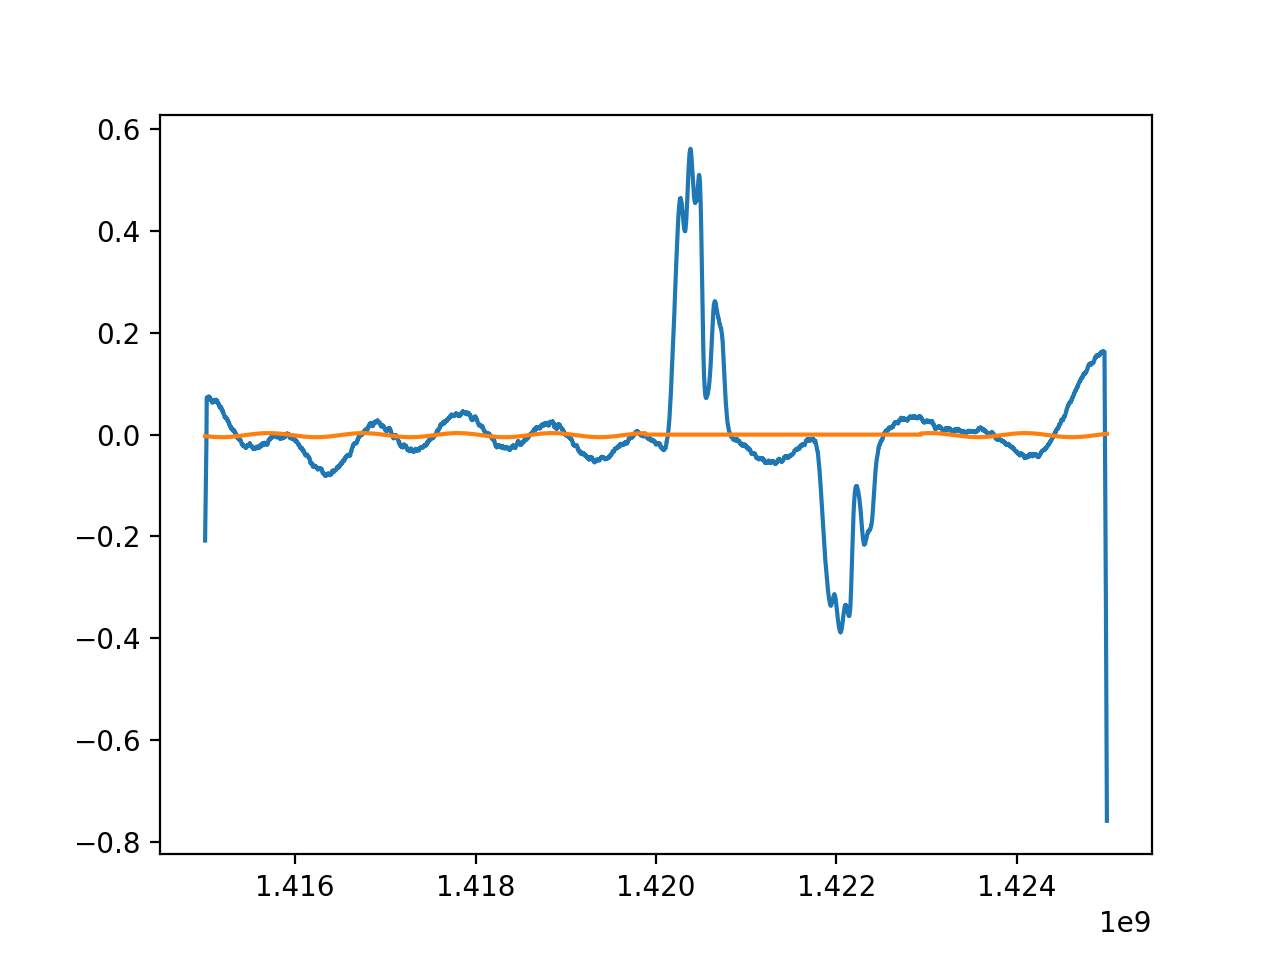

In [1248]:
plt.figure()
plt.plot(t[3:-3], new_data[3:-3])
plt.plot(t[3:-3],fit_2)

<IPython.core.display.Javascript object>


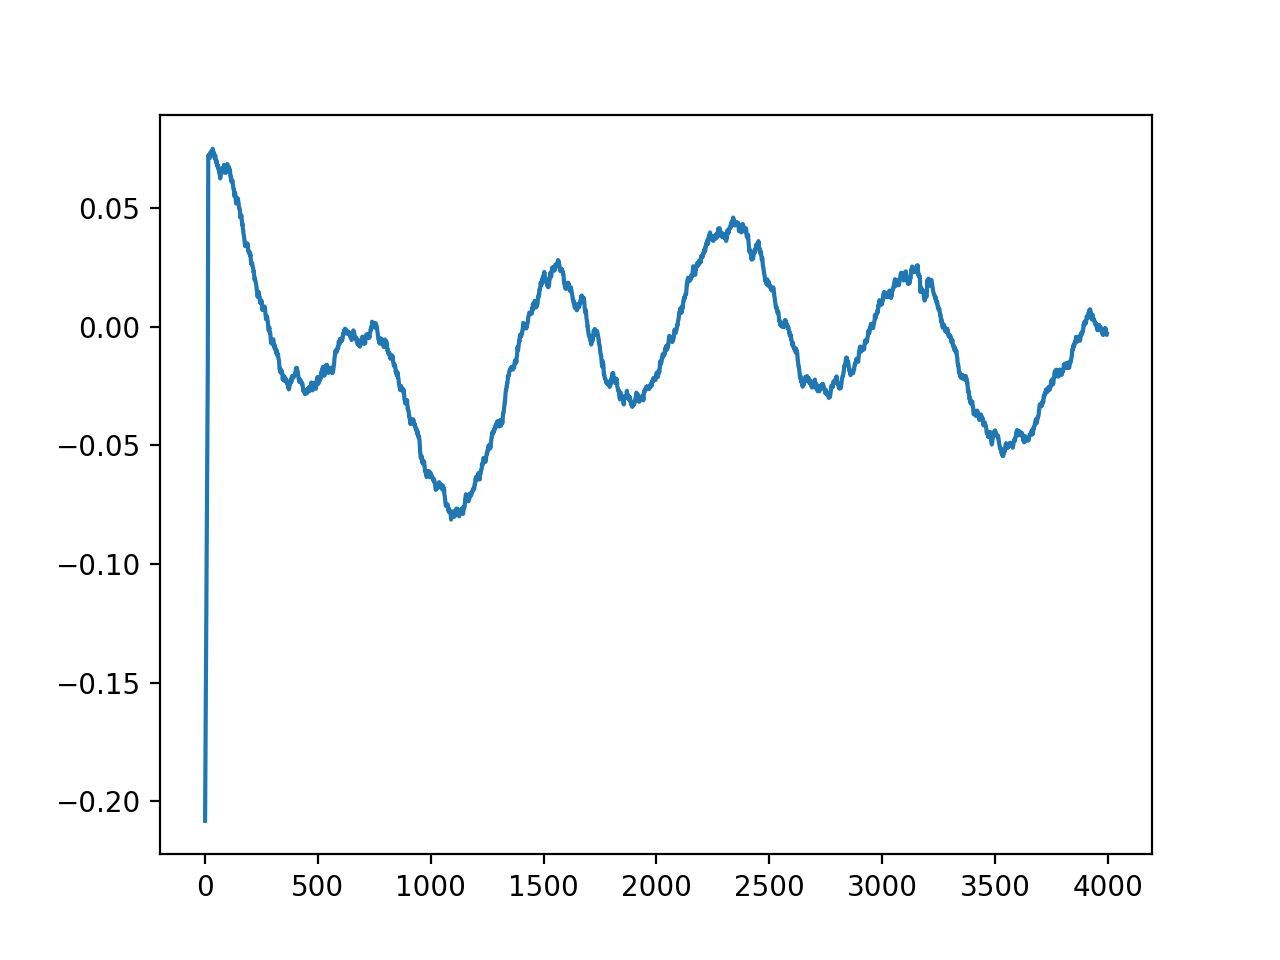

In [1249]:
plt.figure()
plt.plot(new_data[3:4000])
# plt.plot(fit_2)

In [1277]:
t_tilde = np.fft.fft(new_data[:4000])
t_tilde[np.arange(-6, 6)] = 0
back_1 = np.fft.ifft(t_tilde)
t_tilde = np.fft.fft(new_data[6000:])
t_tilde[np.arange(-2, 2)] = 0
back_2 = np.fft.ifft(t_tilde)
final = np.concatenate((back_1,new_data[4000:6000], back_2))

In [1278]:
np.argmax(t_tilde)

1930

In [1280]:
final[:2500] = 0
final[5200:] = 0

<IPython.core.display.Javascript object>


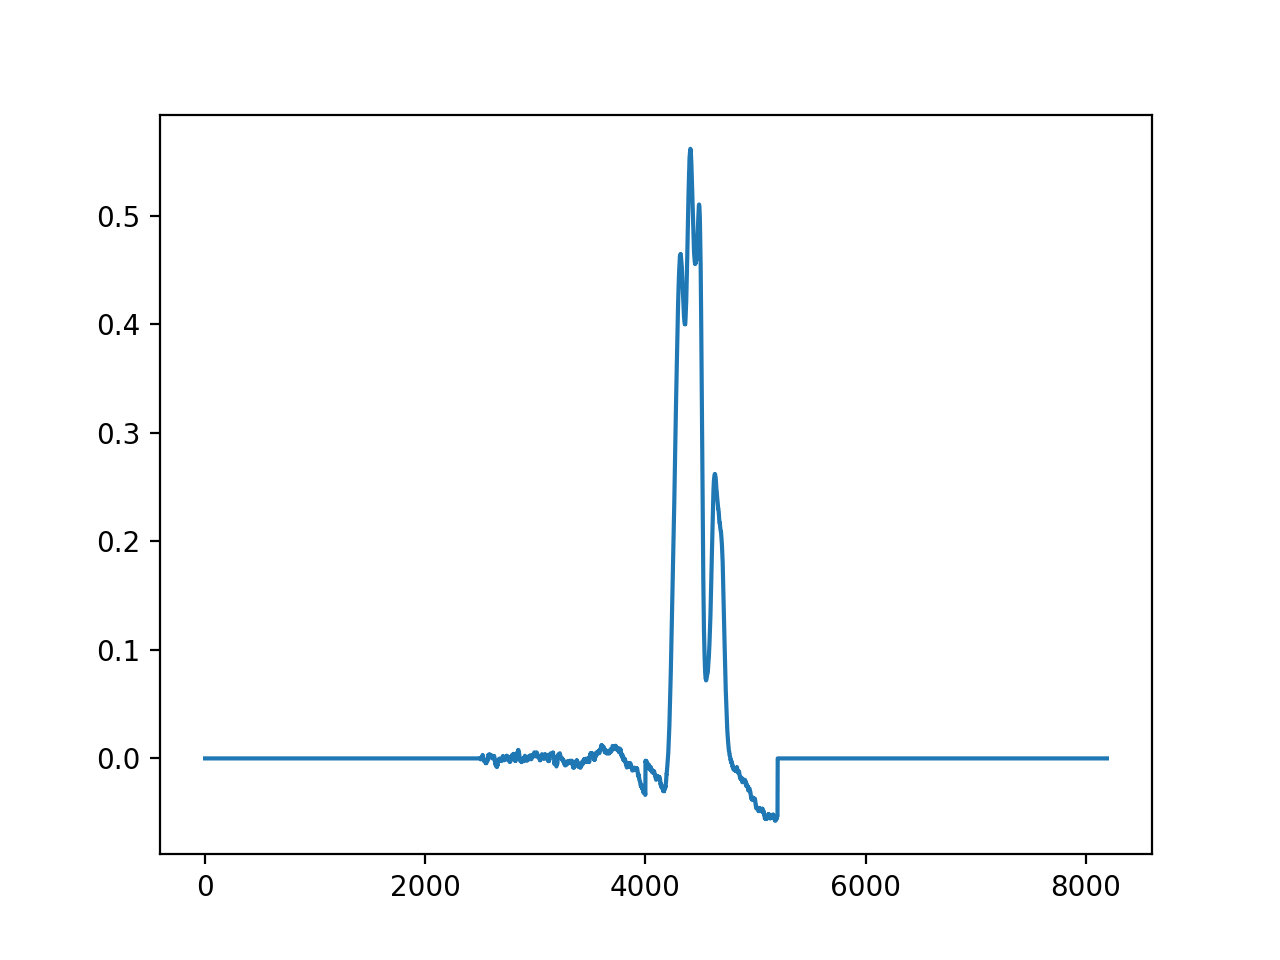

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [1281]:
plt.figure()
plt.plot(final)

In [1263]:
t_tilde = np.fft.fft(new_data[6000:])

<IPython.core.display.Javascript object>


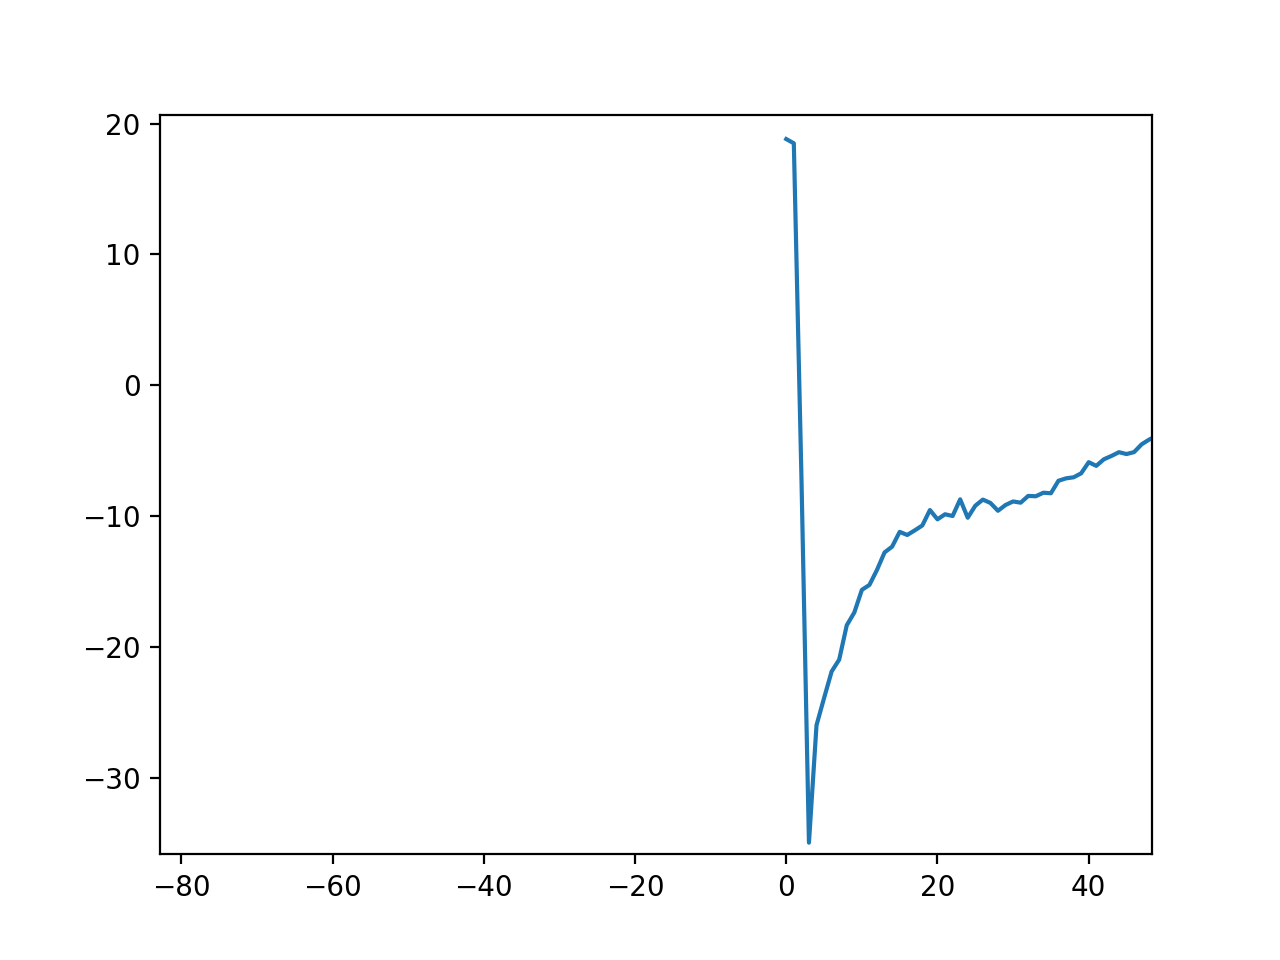

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [1264]:
plt.figure()
plt.plot(t_tilde)
# plt.plot(new_data)

In [1041]:
fit = poly(t[:2200], new_data[:2200], 30)

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/maxlee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


In [1042]:
array([ 6.44237124e-02,  2.29950861e-06, -7.10709003e+02,  5.53812022e-03])


NameError: name 'array' is not defined

In [1043]:
2.5*popt[1]

5.7487715296065555e-06

<IPython.core.display.Javascript object>


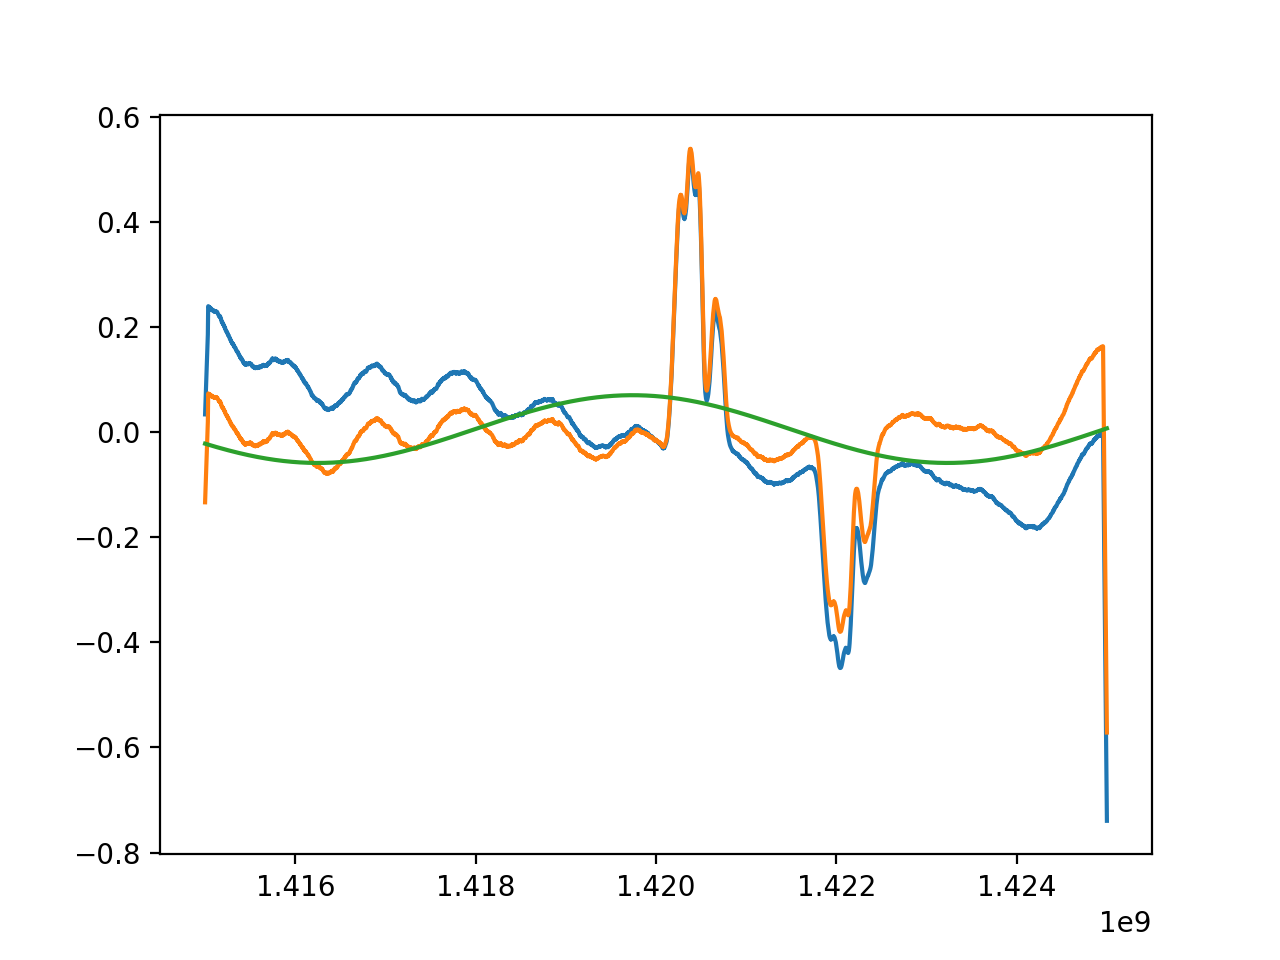

In [1044]:
plt.figure()
plt.plot(t, test)
plt.plot(t, new_data)
# plt.plot(t[:2200], fit[:2200])
# plt.plot(t, sin_check)
plt.plot(t, popt[0]*np.sin(9e-7*t+popt[2])+popt[3])

In [1026]:
v = 3e8*(1420.4e6 - t)/1420.4e6/1e3

<IPython.core.display.Javascript object>


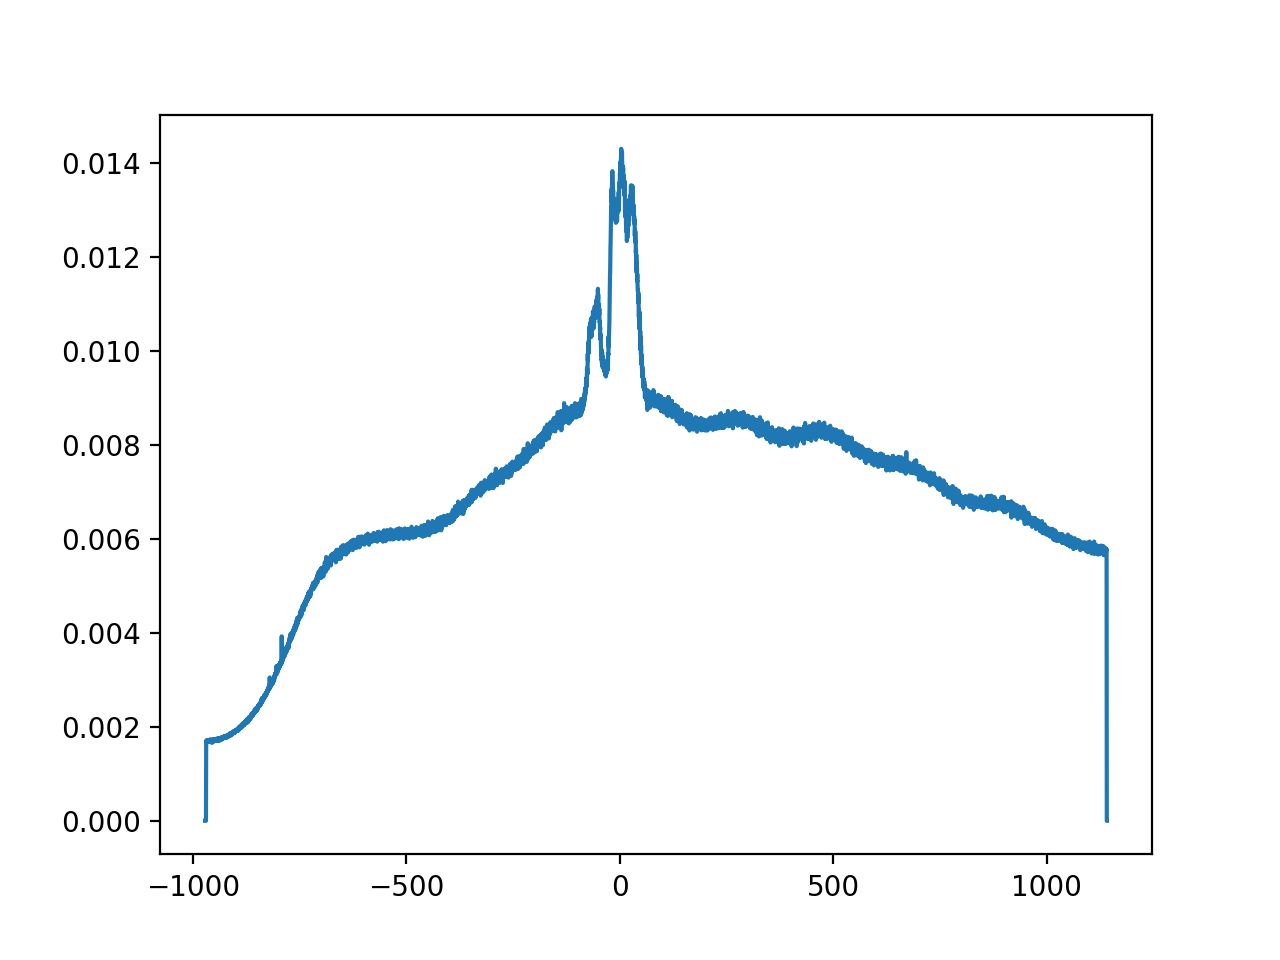

In [1027]:
plt.figure()
plt.plot(v, on_avg)

In [937]:
test_tilde = np.fft.fft(new_data)
test_tilde_2 = np.fft.fft(test_2)

In [894]:
test_tilde[[-3,-2,-1, 1, 2, 3]] = 0
test_back = np.fft.ifft(test_tilde)

<IPython.core.display.Javascript object>


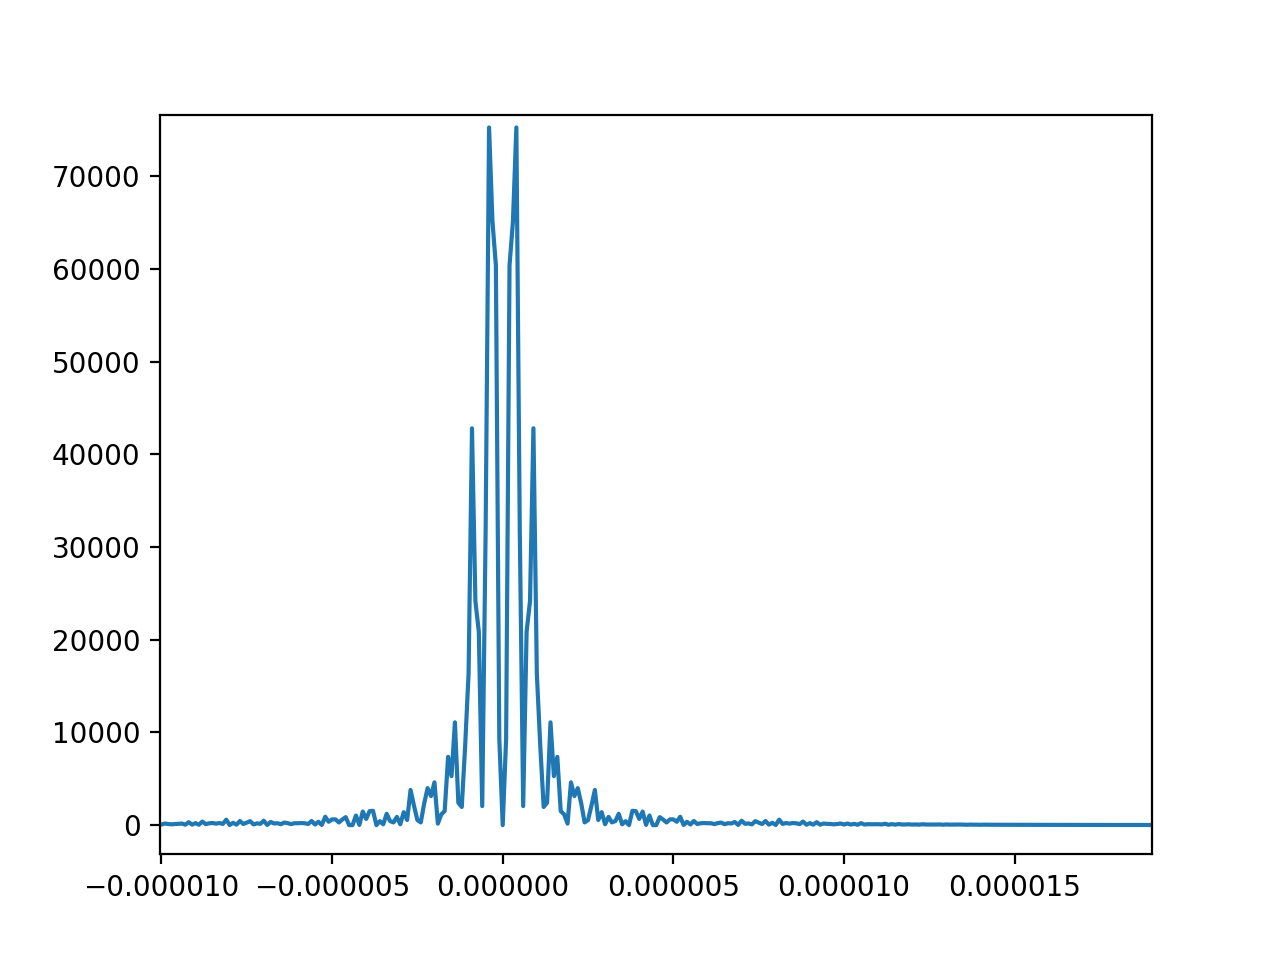

In [1010]:
plt.figure()
plt.plot(np.fft.fftshift(tau), np.fft.fftshift(np.abs(test_tilde)**2))


In [1014]:
tau[45]

4.499450683860222e-06

In [1001]:
np.where(tau>4.599e-6)

(array([  46,   47,   48, ..., 4093, 4094, 4095]),)

In [1018]:
test_tilde[[-45,-44,-46, -47, 44,45, 46, 47] ]= 0

In [1019]:
back = np.fft.ifft(test_tilde)

<IPython.core.display.Javascript object>


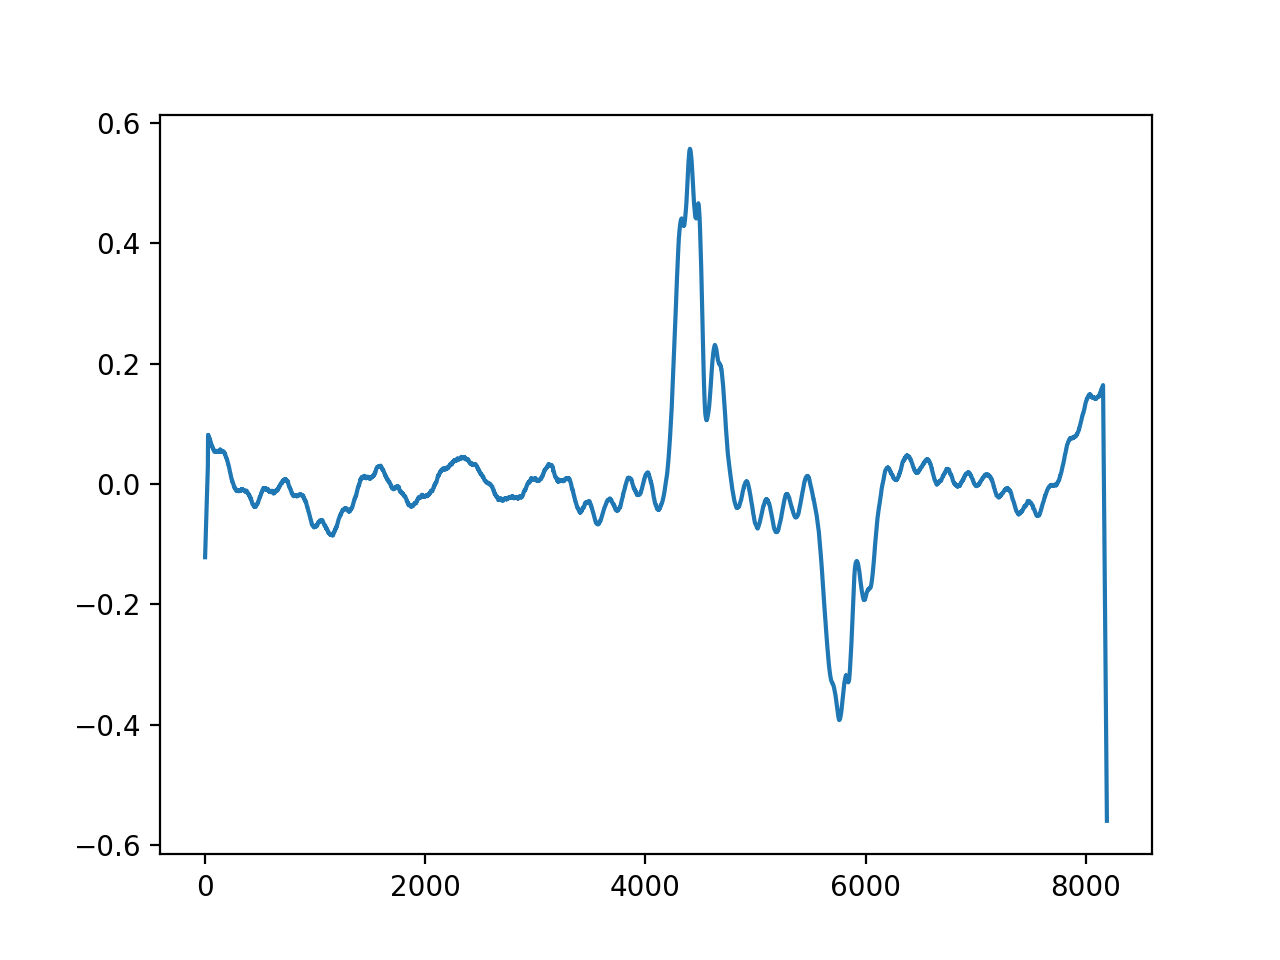

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [1020]:
plt.figure()
plt.plot(back)

### 

In [940]:
np.argmax(test_tilde)

2

In [944]:
def get_sin(t, a, b, c, d):
    return a*np.sin(b*t+c)+d


In [945]:
tau  = np.fft.fftfreq(len(t), np.median(np.diff(t)))

In [983]:
popt, popc = curve_fit(get_sin, t, new_data, p0=[1,1*9e-7, 1, 1])

In [987]:
popt[2]*=2

In [988]:
popt

array([ 6.44237124e-02,  2.29950861e-06, -7.10709003e+02,  5.53812022e-03])

In [989]:
sin_check = get_sin(t, *popt)

<IPython.core.display.Javascript object>


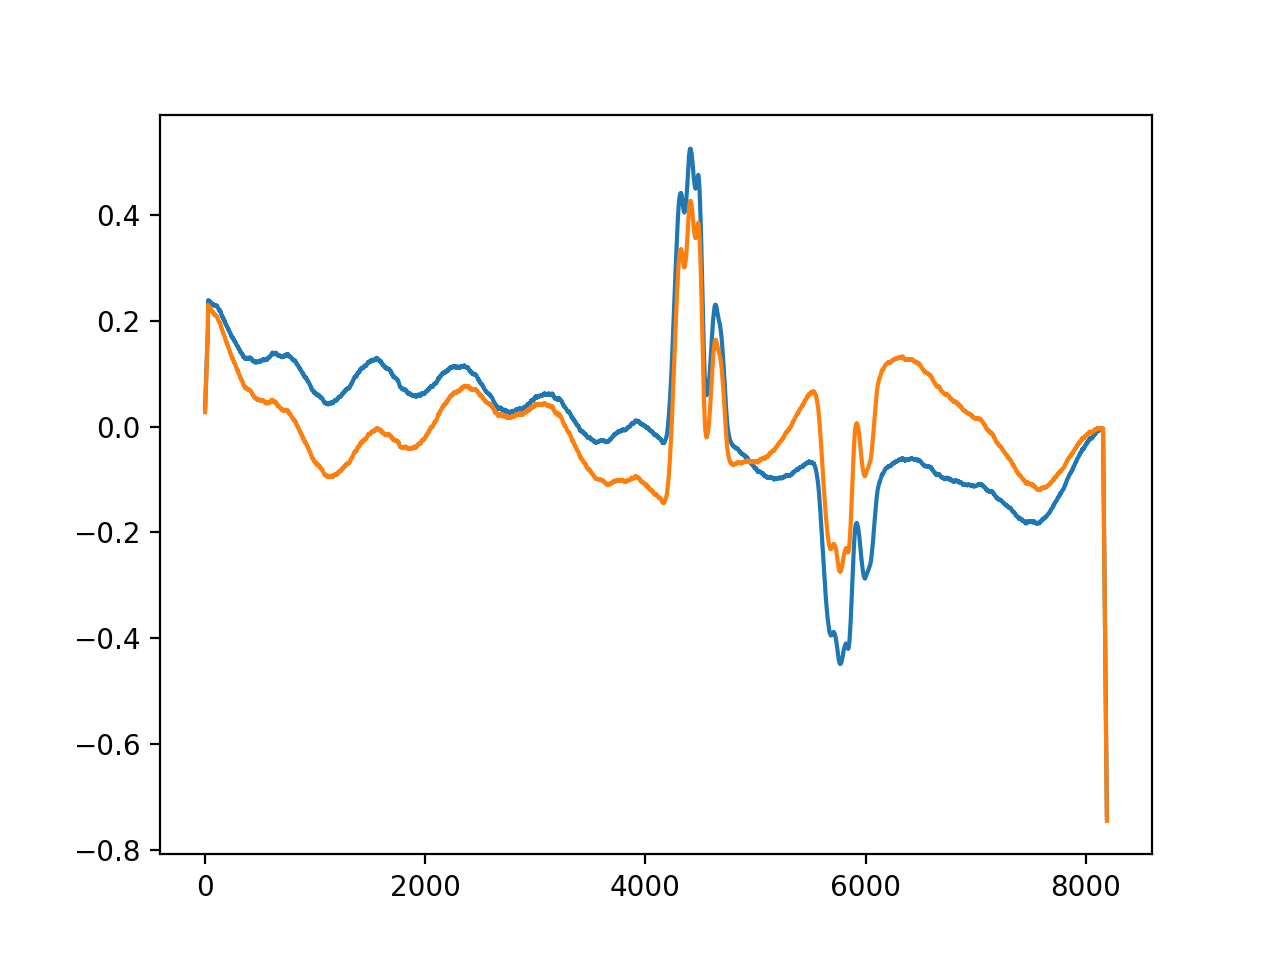

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [897]:
plt.figure()
plt.plot(test)
plt.plot(test_back)

In [721]:
tau = np.fft.fftfreq(len(t), np.median(np.diff(t)))

In [722]:
tau[2]

1.999755859493432e-07

In [664]:
def fit_sin(t, a, b, c, d):
    return a*np.sin(b*t+c)+d

In [648]:
from scipy.optimize import curve_fit

In [746]:
popt, popc = curve_fit(fit_sin, t[3:-3], test[3:-3]-f[3:-3], p0=[1,2 , np.pi/2, 1], method='trf')

In [747]:
popt

array([3.67510279e-04, 2.00000005e+00, 2.84942848e+00, 7.27312185e-04])

In [748]:
tau[15]

1.499816894620074e-06

In [749]:
fit = fit_sin(t[:4221], *popt)

In [750]:
test_back = np.fft.ifft(test_tilde)

In [758]:
test_tilde[[-28, 28]] = 0

In [759]:
test_back = np.fft.ifft(test_tilde)

In [760]:
fit_0 = np.polyfit(t, test, 12)

/Users/maxlee/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [761]:
f = poly(t, fit_0)

<IPython.core.display.Javascript object>


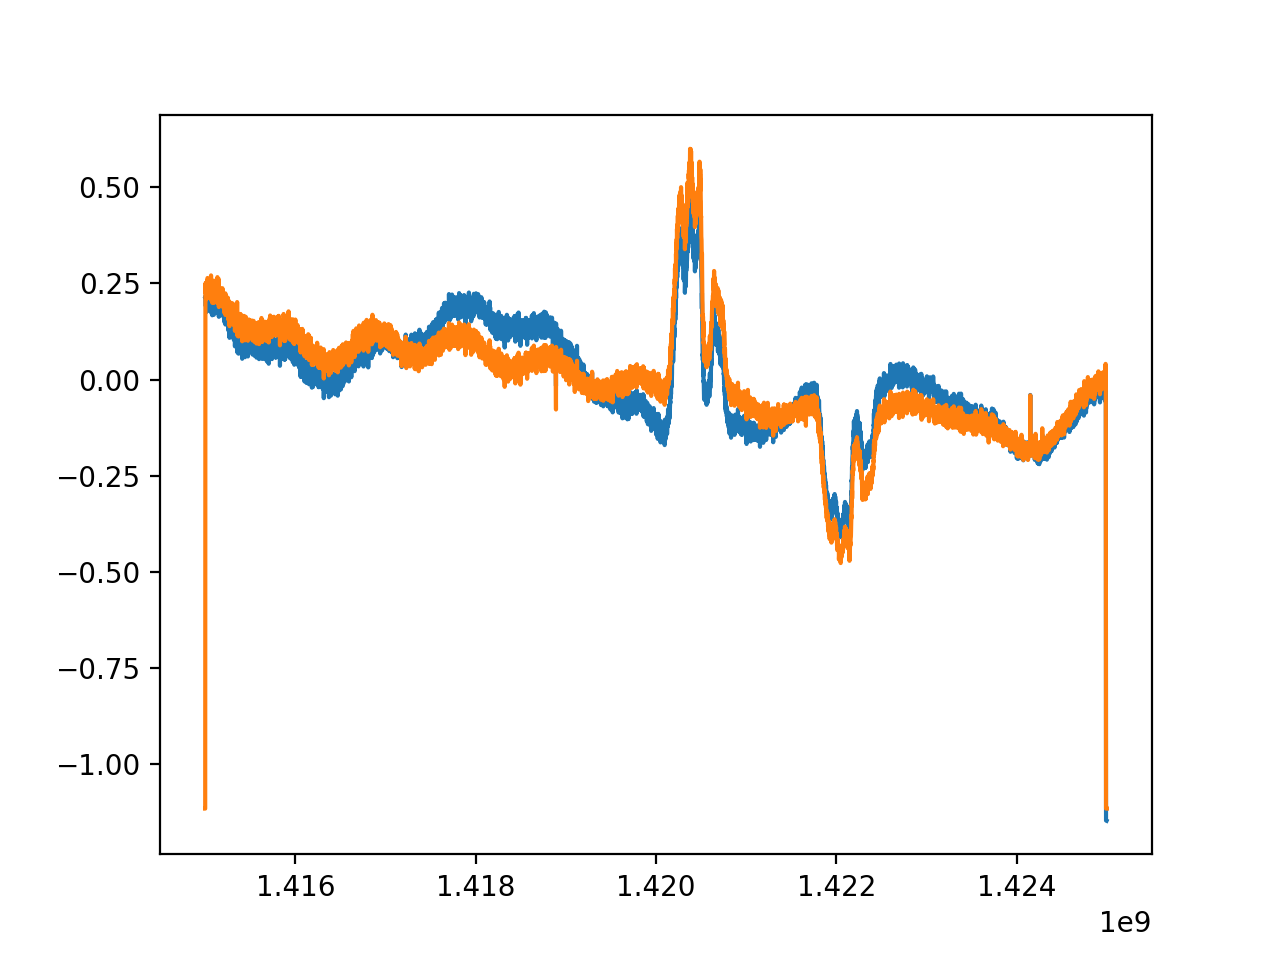

/Users/maxlee/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [763]:
plt.figure()
plt.plot(t[3:-3], test_back[3:-3])
plt.plot(t, test)
# plt.plot(t, f)
# plt.plot(t, fit)